# PART1 Multi-Layer Neural Network

In this part of the assignment, you have to implement multi layer neural network for
classification. In other words your network consists of one input layer, n hidden layer(s)
and one output layer. You will implement forward and backward propagations with
the loss function and learning setting. Actually, you will implement a back-propagation
algorithm to train a neural network

### Importing Necessary Libraries

In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Data Reading and Preprocessing

In [2]:
# Applies min max normalization on image
def min_max_normalization(data):
    data = (data-data.min())/(data.max()-data.min())
    return data

# Functions to read image
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        img = min_max_normalization(img)
        img = np.array(img)
        if img is not None:
            images.append(img)
    return images

def create_dataset_img_array(dataset_location,types):
    images_all_types = []
    for flower_type in types:
        dataset_location1 = dataset_location + flower_type + "/"
        images_all_types.append(load_images_from_folder(dataset_location1))
    return images_all_types

In [3]:
# Paths to datasets
test_data = "C:/Users/Asus/Desktop/BBM409/as3/test/"
validation_data = "C:/Users/Asus/Desktop/BBM409/as3/val/"
train_data = "C:/Users/Asus/Desktop/BBM409/as3/train/"

# list of flower types in the dataset
flower_types = ["aster","calendula","california_poppy","coreopsis","daisy","dandelion","iris","lavender","lily","marigold","orchid","poppy","rose","sunflower","tulip"]

In [4]:
# Creating datasets
train_images = create_dataset_img_array(train_data,flower_types)
validation_images = create_dataset_img_array(validation_data,flower_types)
test_images = create_dataset_img_array(test_data,flower_types)

#Printing first image in train dataset to check if it is read and normalized correctly
print(train_images[0][0])
# Checking the type of the images array
print(type(train_images))

[[0.6627451  0.68627451 0.63137255 ... 0.7254902  0.76862745 0.70196078]
 [0.66666667 0.68627451 0.63137255 ... 0.71764706 0.77647059 0.72156863]
 [0.67058824 0.68627451 0.62352941 ... 0.70588235 0.78431373 0.7372549 ]
 ...
 [0.59607843 0.59607843 0.6        ... 0.63529412 0.64705882 0.6627451 ]
 [0.58823529 0.56862745 0.6        ... 0.59607843 0.6        0.59607843]
 [0.58823529 0.56862745 0.6        ... 0.59607843 0.6        0.59607843]]
<class 'list'>


In [5]:
#printing lenth of the images array to make sure they are same
print(len(train_images))
print(len(validation_images))
print(len(test_images))

#printing number of the images in one category to make sure they are same
print(len(train_images[0]))
print(len(validation_images[0]))
print(len(test_images[0]))

#printing shapes of the images to check if they are same
print(train_images[0][0].shape)
print(validation_images[0][0].shape)
print(test_images[0][0].shape)

15
15
15
700
150
150
(186, 272)
(183, 275)
(183, 276)


In [6]:
#Shapes of all images are not same
# find max min and mean shapes to decide resize shape
# Finding min max and mean shapes will give us an idea about image shapes. 
# We can use this information for deciding image resizing shape.
def min_max_mean_shape(images):
    min_x  = images[0][0].shape[0]
    max_x = images[0][0].shape[0]
    sum_x = 0
    min_y  = images[0][0].shape[1]
    max_y = images[0][0].shape[1]
    sum_y = 0
    for i in images:
        for img in i:
            x = img.shape[0]
            y = img.shape[1]
            min_x = min(min_x,x)
            max_x = max(max_x,x)
            sum_x+=x
            
            min_y = min(min_y,y)
            max_y = max(max_y,y)
            sum_y+=y
    num = len(images) * len(images[0])
    avr_x = sum_x/num
    avr_y = sum_y/num
    return min_x,max_x,avr_x,min_y,max_y,avr_y
 

# check sizes in the order min_x,max_x,avr_x,min_y,max_y,avr_y 
print(min_max_mean_shape(train_images))
print(min_max_mean_shape(validation_images))
print(min_max_mean_shape(test_images))               

(94, 462, 229.60695238095238, 100, 616, 246.57438095238095)
(100, 4000, 234.85644444444443, 100, 6000, 249.99155555555555)
(100, 995, 231.22577777777778, 100, 850, 246.60355555555554)


In [7]:
# Need to resize all images in one shape because number of input parameters must be same
# and number of input parameters is img_size_x * img_size_y
# Need to decide resize shape
# min length is 94 while min width is 100
# I tried to run model with img size 94*100 but it runs very slow
# So I decided to use img shape size 40,40 to run program faster

resize_x = 40
resize_y = 40

#Function for resizing entire dataset
def resize_dataset(images):
    images1 = []
    for i in images:
        for img in i:
            img = cv2.resize(img,(resize_y,resize_x))
            images1.append(img)
    return images1

#reshape all images in train, test, val
train_images= resize_dataset(train_images)
validation_images = resize_dataset(validation_images)
test_images = resize_dataset(test_images)

In [8]:
# check resized shape
print(train_images[0].shape)
print(validation_images[0].shape)
print(test_images[0].shape)

# check number of images
print(len(train_images))
print(len(validation_images))
print(len(test_images))

(40, 40)
(40, 40)
(40, 40)
10500
2250
2250


In [9]:
# creates label array with given number of images in the dataset
def create_label(img_num): 
    labels=[]
    for i in range(15):
        l = [i] * (int(img_num/15))
        # [i, i, i, i, i, ...]
        labels.append(l)
    y_flat = np.ravel(labels)
    y_encoded = []
    for j in range(len(y_flat)):
        l = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        num = y_flat[j]
        l[num]= 1
        l = np.array(l)
        y_encoded.append(l)
    return np.asarray(y_encoded)

In [10]:
#Creates labels for datasets
train_y = create_label(len(train_images))
val_y = create_label(len(validation_images))
test_y = create_label(len(test_images))

In [11]:
# print shapes of label arrays to make sure they have created right
print((train_y).shape)
print((val_y).shape)
print((test_y).shape)

# print first label value of any dataset to check if it is created right
print(train_y[0])

(10500, 15)
(2250, 15)
(2250, 15)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
# funtion to combine x and y 
def combine_xy(data_x,data_y):
    num = len(data_x)
    data_xy = []
    for i in range(num):
        row = [] 
        row.append(data_x[i])
        row.append(data_y[i])
        data_xy.append(row)
    data_xy = np.array(data_xy)
    return data_xy

# combine x and y to shuffle them later
train_xy = combine_xy(train_images, train_y)
val_xy = combine_xy(validation_images, val_y)
test_xy = combine_xy(test_images, test_y)

# print the shapes to make sure they combined 
print(train_xy.shape)
print(val_xy.shape)
print(test_xy.shape)

(10500, 2)
(2250, 2)
(2250, 2)


C:\Users\Asus\AppData\Local\Temp\ipykernel_3732\3755753487.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_xy = np.array(data_xy)


In [13]:
#shuffle the datasets
np.random.shuffle(train_xy) 
np.random.shuffle(val_xy) 
np.random.shuffle(test_xy) 

#make sure it is shuffled
print(train_xy[0][1])
print(val_xy[0][1])
print(test_xy[0][1])


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [14]:
#divide all datasets into x and y again
train_x = train_xy[:,0]
train_y = train_xy[:,1]
val_x = val_xy[:,0]
val_y = val_xy[:,1]
test_x = test_xy[:,0]
test_y = test_xy[:,1]

In [15]:
# function to extract one hot encoding labels from list of list to list from the y_data
def extract_labels(y_data):
    extracted = []
    for l in y_data:
        one_hot_encoded=[]
        for i in l:
            one_hot_encoded.append(i)
        extracted.append(one_hot_encoded)
    return np.array(extracted)

In [16]:
# transform y data to right shape to be used in neural network model
train_y = extract_labels(train_y).T
val_y = extract_labels(val_y).T
test_y = extract_labels(test_y).T

In [17]:
# printing shapes to be sure they are right to be used in neural network model
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(15, 10500)
(15, 2250)
(15, 2250)


In [18]:
# function for flatting the image 
# dataset was a nested array before this function will combines all images in one array
def flat_x_array(data):
    flat_x = []
    for img in data:
        img = np.ravel(img)
        flat_x.append(img)
    return np.array(flat_x)

# transform x data to right shape to be used in neural network model
train_x = flat_x_array(train_images).T
val_x = flat_x_array(validation_images).T
test_x = flat_x_array(test_images).T

In [19]:
# printing shapes to be sure they are right to be used in neural network model
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1600, 10500)
(1600, 2250)
(1600, 2250)


## Neural Network

### Neural Network Implementation

In [20]:
# Function to initialize weight of parameters for all layers
# if the layer is relu use he initialization
# if the layer is output(softmax) or sigmoid use xavier initialization
# initialize bias to 1 for all layers
def initialize_parameters(layer_sizes, activations):
    np.random.seed(42)
    parameters_W = []
    parameters_b = []
    
    #for all layers besides input
    for l in range(1, len(layer_sizes)):
        if activations[l-1] == 'relu':
            # He initialization for ReLU layers
            W = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * np.sqrt(2 / layer_sizes[l-1])
        else:
            # Xavier initialization for other activation functions
            W = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * np.sqrt(1 / layer_sizes[l-1])
        
        b = np.zeros((layer_sizes[l], 1))
        parameters_W.append(W)
        parameters_b.append(b)
    return parameters_W, parameters_b

# ACTIVATION FUNCTIONS

# RELU Function
def relu(z):
    return np.maximum(0, z)

# Sigmoid Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Softmax Function for output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # for numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True) +1e-10


# Function for forward propagation in the model
def forward_propagation(X, parameters_W, parameters_b,activations):
    intermediate_Z = []
    intermediate_A = []
    A = X
    L = len(parameters_b) 
    for l in range(0, L-1):
        Z = np.dot(parameters_W[l], A) + parameters_b[l]
        if activations[l] == 'relu':
            A = relu(Z)
        elif activations[l] == 'sigmoid':
            A = sigmoid(Z)
        intermediate_Z.append(Z)
        intermediate_A.append(A)
  
    Z_output = np.dot(parameters_W[L-1], A) + parameters_b[L-1]
    A_output = softmax(Z_output)
    intermediate_Z.append(Z_output)
    intermediate_A.append(A_output)
   
    return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)


#sum of negative log likelihood loss function
def compute_loss(A_output, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A_output + 1e-10)) / m
    return loss

#computing the gradients of the loss with respect to the parameters
def backward_propagation(X, Y, parameters_W, parameters_b, intermediate_A, intermediate_Z, activations):
    
    grads_dW = []
    grads_db = []
    L = len(parameters_b)
    
    for i in range(L):
        grads_db.append(np.zeros_like(parameters_b[i]))
        grads_dW.append(np.zeros_like(parameters_W[i]))
    
    m = X.shape[1]
    
    A_output = intermediate_A[-1]
   
    dZ_output = A_output - Y

    grads_dW[L-1] = np.dot(dZ_output,intermediate_A[-2].T ) / m
    grads_db[L-1] = np.sum(dZ_output, axis=1, keepdims=True) / m

    dA = np.dot(parameters_W[L-1].T, dZ_output)

    for l in range(L-2,0,-1):
        if activations[l-1] == 'relu':
            dZ = dA * (intermediate_Z[l] > 0)
        elif activations[l-1] == 'sigmoid':
            dZ = dA * (intermediate_A[l] * (1 - intermediate_A[l]))

      
        grads_dW[l] = np.dot(dZ, intermediate_A[l-1].T) / m
        grads_db[l] = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(parameters_W[l].T, dZ)

    return np.array(grads_dW), np.array(grads_db)

# updates parameters in each layer
def update_parameters(parameters_W, parameters_b, grads_dW, grads_db, learning_rate):
    
    for l in range(len(parameters_W)):
        parameters_W[l] -= learning_rate * grads_dW[l]
        parameters_b[l] -= learning_rate * grads_db[l]

    return parameters_W, parameters_b

# function for mini batch graident descent 
def mini_batch_gradient_descent(X, Y, val_X, val_Y, parameters_W, parameters_b, activations1, initial_learning_rate, decay_rate, num_epochs, batch_size):
    m = X.shape[1]
    train_losses = []
    val_losses = []
    early_stopping_check_interval = 10
    
    # For each epoch
    for epoch in range(num_epochs):
        print("In epoch:", epoch)
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[:, shuffled_indices]
        Y_shuffled = Y[:, shuffled_indices]
        
        # For each batch
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            A_output, intermediate_A, intermediate_Z = forward_propagation(X_batch, parameters_W, parameters_b, activations1)
            loss = compute_loss(A_output, Y_batch)
            grads_dW, grads_db = backward_propagation(X_batch, Y_batch, parameters_W, parameters_b, intermediate_A, intermediate_Z, activations1)
            parameters_W, parameters_b = update_parameters(parameters_W, parameters_b, grads_dW, grads_db, initial_learning_rate)
            
        print(f"Training Loss in this epoch: {loss:.4f}")
        train_losses.append(loss)
        # Update learning rate with Learning rate decay
        initial_learning_rate *= 1 / (1 + decay_rate * epoch)
        
        # Compute validation error
        val_A_output, _, _ = forward_propagation(val_X, parameters_W, parameters_b, activations1)
        val_loss = compute_loss(val_A_output, val_Y)
        print(f'Validation Loss at epoch {epoch}: {val_loss:.4f}')
        val_losses.append(val_loss)
        
        # Check for early stopping
        if epoch % early_stopping_check_interval == 0 and epoch>0:
            if val_loss >= min(val_losses[-early_stopping_check_interval:]):
                print(f'Early stopping at epoch {epoch}')
                return parameters_W, parameters_b, train_losses, val_losses,epoch+1


    return parameters_W, parameters_b, train_losses, val_losses,epoch+1

# Function to plot train and validation cost in one graph
def plot_losses(train_losses,val_losses,num_epochs):
    # Plot training and validation losses
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
# Function to do inference and calculate accuracy precision recall f1 and confusion matriz
def predict_and_evaluate(test_X, test_Y, parameters_W, parameters_b, activations):
    # Forward pass to get predictions
    A_output, _, _ = forward_propagation(test_X, parameters_W, parameters_b, activations)

    # Convert predicted probabilities to class predictions
    predictions = np.argmax(A_output, axis=0)

    # Convert one-hot encoded labels to class labels
    true_labels = np.argmax(test_Y, axis=0)

    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)

    # Calculate precision, recall, f1-score, and support
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    return predictions, accuracy, precision, recall, f1, conf_matrix

# Function for displaying test results accuracy, precision, recall, f1 and plot confusing matrix
def display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix):
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1-Measure: {test_f1:.4f}')
    print('Confusion Matrix:')
    # Display confusion matrix
    display_labels1= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=display_labels1)  
    display.plot(cmap='viridis', values_format='d')  
    plt.show()

# Function for visualizing parameters as images
def visualize_parameters(trained_parameters_w):
   
    trained_parameters_w = [np.array(parameters_w) for parameters_w in trained_parameters_w]

    for i, params in enumerate(trained_parameters_w):
        print(f"Parameters for layer {i + 1} shape: {params.shape}")

    # Iterate over each layer and visualize it
    for i, params in enumerate(trained_parameters_w):
        plt.figure()
        plt.imshow(params, cmap='gray')
        plt.title(f'Learned parameters for layer {i + 1}')
        plt.axis('off')

    plt.show()
    

### Creating the first model

In [21]:
# Size of input layer will be length of img * width of img
number_of_input_parameter = resize_x * resize_y
#it will be 1 or 2 like it is stated in homework pdf
# First I used 2 hidden layers and did 16 experiments on it. Then later in the code I used 1 hidden layer
number_of_hidden_layers = 2  

In [22]:
# Calculates number of hidden layer units
# This function will create an array of hidden layer sizes getting means average of input size and output size 
# and multiply it with some number to create a list with length of hidden layer size
def return_number_of_hidden_layer_units(number_of_hidden_layers,number_of_input_parameters):
    #output layer size is 15
    #input layer size is number_of_input_parameters
    units = []
    sum1 = number_of_input_parameters + 15
    for i in range(1, number_of_hidden_layers+1):
        num = int(i * sum1 / (number_of_hidden_layers+1))
        units.append(num)
    units.reverse()
    return units

In [23]:
# Create list of hidden layer sizes
no_units = return_number_of_hidden_layer_units(number_of_hidden_layers,number_of_input_parameter)
print(no_units)

# layer size is a list of number of units in each layer [input hidden1 ... hiddenn output]
layer_sizes = [number_of_input_parameter]
for i in no_units:
    layer_sizes.append(i)
layer_sizes.append(15)
# print size of layers in the model
print(layer_sizes)

[1076, 538]
[1600, 1076, 538, 15]


In [24]:
# CREATING ACTIVATION LIST
# It is a list of Activation functions for each hidden layer and output layer
activations = []
for i in range(number_of_hidden_layers):
    activations.append("relu")
activations.append("softmax")
print(activations)

['relu', 'relu', 'softmax']


In [25]:
#Set initial weights for W and b
initial_parameters_W, initial_parameters_b = initialize_parameters(layer_sizes, activations)

### Experiments on first model

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_3732\845997867.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_3732\845997867.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7720
Validation Loss at epoch 0: 2.9940
In epoch: 1
Training Loss in this epoch: 2.6930
Validation Loss at epoch 1: 2.8013
In epoch: 2
Training Loss in this epoch: 2.7610
Validation Loss at epoch 2: 2.7523
In epoch: 3
Training Loss in this epoch: 2.8044
Validation Loss at epoch 3: 2.7222
In epoch: 4
Training Loss in this epoch: 2.7268
Validation Loss at epoch 4: 2.7169
In epoch: 5
Training Loss in this epoch: 2.6381
Validation Loss at epoch 5: 2.7167
In epoch: 6
Training Loss in this epoch: 2.7959
Validation Loss at epoch 6: 2.7167
In epoch: 7
Training Loss in this epoch: 2.7446
Validation Loss at epoch 7: 2.7167
In epoch: 8
Training Loss in this epoch: 2.6686
Validation Loss at epoch 8: 2.7167
In epoch: 9
Training Loss in this epoch: 2.6606
Validation Loss at epoch 9: 2.7167
In epoch: 10
Training Loss in this epoch: 2.6525
Validation Loss at epoch 10: 2.7167
Early stopping at epoch 10


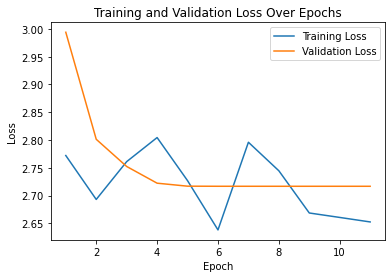

Test Accuracy: 5.78%
Test Precision: 0.0588
Test Recall: 0.0578
Test F1-Measure: 0.0562
Confusion Matrix:


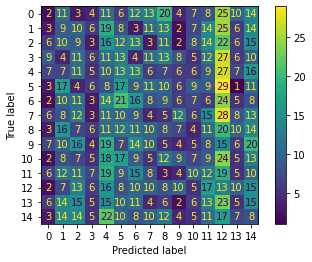

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


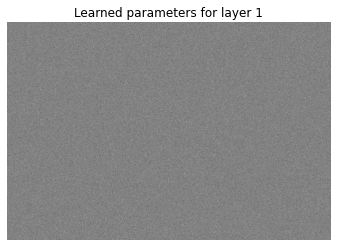

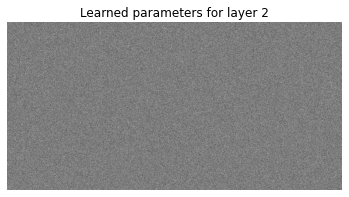

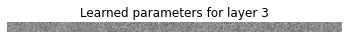

In [26]:
#Experiment1
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

In [29]:
def visualize_hidden_layer_weights(weights_w,weight_b, num_neurons, image_shape):
    num = num_neurons[-2]
    fig, axes = plt.subplots(1, num, figsize=(10, 1))
    w = weights_w[-2]
    b = weight_b[-2]
    for i in range(num):
        # Extract weights for the i-th neuron
        neuron_weights = w[i, :]
        neuron_b = b[i,:]

        # Reshape into an image
        neuron_image = neuron_weights.reshape(image_shape)

        # Plot the image
        axes[i].imshow(neuron_image, cmap='gray')
        axes[i].axis('off')

    plt.show()




visualize_hidden_layer_weights(trained_parameters_w,trained_parameters_b,layer_sizes, image_shape=(40,40))

ValueError: cannot reshape array of size 1076 into shape (40,40)

Error in callback <function flush_figures at 0x000001F3C55838B0> (for post_execute):


KeyboardInterrupt: 

While training error shows a decrease and an increase and a decrease , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 1,2,5 and 12(class names starts from 0 in the confusion matrix) more than other classes.

In [27]:
#Experiment2
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_3732\845997867.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_3732\845997867.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7583
Validation Loss at epoch 0: 2.9564
In epoch: 1
Training Loss in this epoch: 2.7097
Validation Loss at epoch 1: 2.8181
In epoch: 2
Training Loss in this epoch: 2.8039
Validation Loss at epoch 2: 2.7714
In epoch: 3
Training Loss in this epoch: 2.6262
Validation Loss at epoch 3: 2.7217
In epoch: 4
Training Loss in this epoch: 2.7450
Validation Loss at epoch 4: 2.7160
In epoch: 5


KeyboardInterrupt: 

While training error shows a decrease and an increase , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 15(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6554
Validation Loss at epoch 0: 2.8912
In epoch: 1
Training Loss in this epoch: 2.7644
Validation Loss at epoch 1: 2.8312
In epoch: 2
Training Loss in this epoch: 2.6511
Validation Loss at epoch 2: 2.7329
In epoch: 3
Training Loss in this epoch: 2.6659
Validation Loss at epoch 3: 2.7215
In epoch: 4
Training Loss in this epoch: 2.6950
Validation Loss at epoch 4: 2.7198
In epoch: 5
Training Loss in this epoch: 2.6083
Validation Loss at epoch 5: 2.7193
In epoch: 6
Training Loss in this epoch: 2.5338
Validation Loss at epoch 6: 2.7192
In epoch: 7
Training Loss in this epoch: 2.6851
Validation Loss at epoch 7: 2.7192
In epoch: 8
Training Loss in this epoch: 2.7628
Validation Loss at epoch 8: 2.7192
In epoch: 9
Training Loss in this epoch: 2.6445
Validation Loss at epoch 9: 2.7192
In epoch: 10
Training Loss in this epoch: 2.6114
Validation Loss at epoch 10: 2.7192
Early stopping at epoch 10


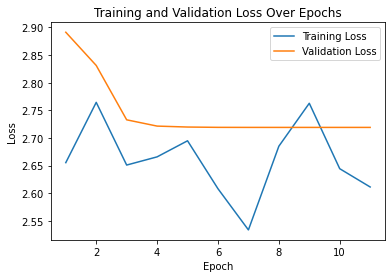

Test Accuracy: 6.58%
Test Precision: 0.0659
Test Recall: 0.0658
Test F1-Measure: 0.0634
Confusion Matrix:


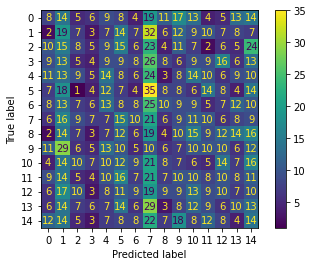

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


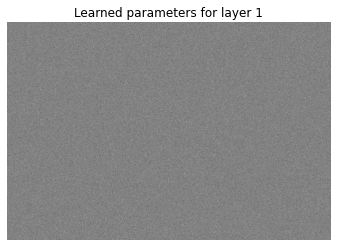

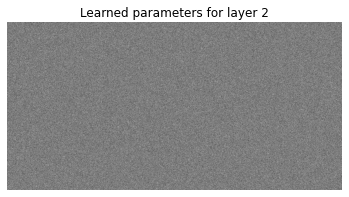

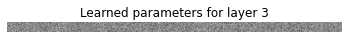

In [ ]:
#Experiment3
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and  a decrease,  validation error didn't continue to decrease after epoch 3. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 3.

Confusion matrix shows that this model is did prone to predict class 8(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5701
Validation Loss at epoch 0: 2.8211
In epoch: 1
Training Loss in this epoch: 2.8349
Validation Loss at epoch 1: 2.8522
In epoch: 2
Training Loss in this epoch: 2.5517
Validation Loss at epoch 2: 2.7555
In epoch: 3
Training Loss in this epoch: 2.6405
Validation Loss at epoch 3: 2.7315
In epoch: 4
Training Loss in this epoch: 2.5757
Validation Loss at epoch 4: 2.7215
In epoch: 5
Training Loss in this epoch: 2.7378
Validation Loss at epoch 5: 2.7203
In epoch: 6
Training Loss in this epoch: 2.6627
Validation Loss at epoch 6: 2.7200
In epoch: 7
Training Loss in this epoch: 2.7501
Validation Loss at epoch 7: 2.7200
In epoch: 8
Training Loss in this epoch: 2.7240
Validation Loss at epoch 8: 2.7200
In epoch: 9
Training Loss in this epoch: 2.5385
Validation Loss at epoch 9: 2.7200
In epoch: 10
Training Loss in this epoch: 2.7647
Validation Loss at epoch 10: 2.7200
Early stopping at epoch 10


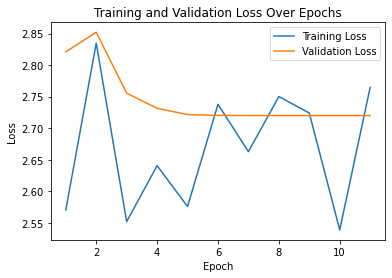

Test Accuracy: 7.24%
Test Precision: 0.0699
Test Recall: 0.0724
Test F1-Measure: 0.0696
Confusion Matrix:


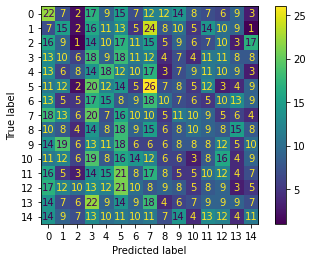

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


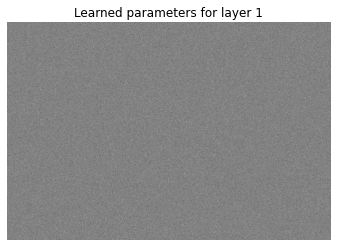

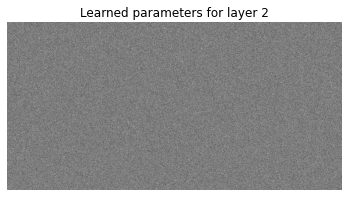

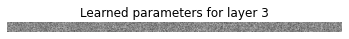

In [ ]:
#Experiment4
trained_parameters_w,trained_parameters_b, train_losses, val_losses, epoch= mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and  a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is did prone to predict class 8(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7641
Validation Loss at epoch 0: 2.8246
In epoch: 1
Training Loss in this epoch: 2.4904
Validation Loss at epoch 1: 2.8139
In epoch: 2
Training Loss in this epoch: 2.6219
Validation Loss at epoch 2: 2.7435
In epoch: 3
Training Loss in this epoch: 2.5905
Validation Loss at epoch 3: 2.7236
In epoch: 4
Training Loss in this epoch: 2.6104
Validation Loss at epoch 4: 2.7212
In epoch: 5
Training Loss in this epoch: 2.5684
Validation Loss at epoch 5: 2.7211
In epoch: 6
Training Loss in this epoch: 2.5359
Validation Loss at epoch 6: 2.7211
In epoch: 7
Training Loss in this epoch: 2.7059
Validation Loss at epoch 7: 2.7210
In epoch: 8
Training Loss in this epoch: 2.7513
Validation Loss at epoch 8: 2.7210
In epoch: 9
Training Loss in this epoch: 2.7653
Validation Loss at epoch 9: 2.7210
In epoch: 10
Training Loss in this epoch: 2.5789
Validation Loss at epoch 10: 2.7210
Early stopping at epoch 10


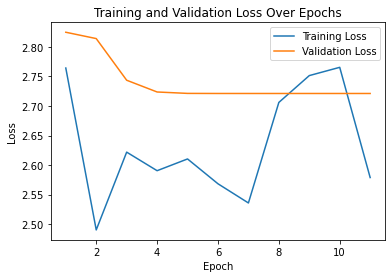

Test Accuracy: 6.76%
Test Precision: 0.0685
Test Recall: 0.0676
Test F1-Measure: 0.0667
Confusion Matrix:


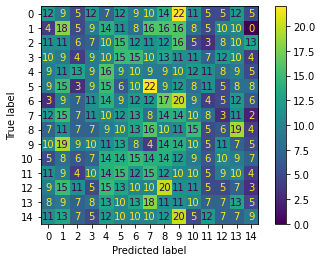

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


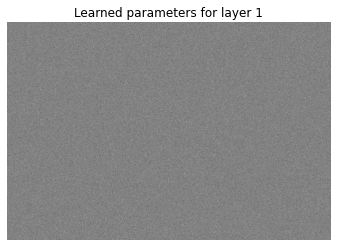

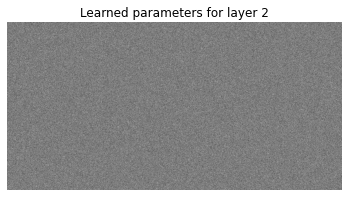

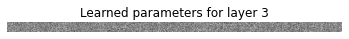

In [ ]:
#Experiment5
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease,an increase and  a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 8,9 and 10(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7913
Validation Loss at epoch 0: 2.7483
In epoch: 1
Training Loss in this epoch: 2.6515
Validation Loss at epoch 1: 2.7676
In epoch: 2
Training Loss in this epoch: 2.5940
Validation Loss at epoch 2: 2.7437
In epoch: 3
Training Loss in this epoch: 2.6420
Validation Loss at epoch 3: 2.7253
In epoch: 4
Training Loss in this epoch: 2.6399
Validation Loss at epoch 4: 2.7232
In epoch: 5
Training Loss in this epoch: 2.4497
Validation Loss at epoch 5: 2.7232
In epoch: 6
Training Loss in this epoch: 2.6789
Validation Loss at epoch 6: 2.7232
In epoch: 7
Training Loss in this epoch: 2.6288
Validation Loss at epoch 7: 2.7232
In epoch: 8
Training Loss in this epoch: 2.5711
Validation Loss at epoch 8: 2.7232
In epoch: 9
Training Loss in this epoch: 2.6359
Validation Loss at epoch 9: 2.7232
In epoch: 10
Training Loss in this epoch: 2.5066
Validation Loss at epoch 10: 2.7232
Early stopping at epoch 10


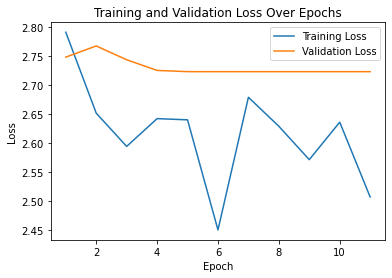

Test Accuracy: 6.89%
Test Precision: 0.0674
Test Recall: 0.0689
Test F1-Measure: 0.0671
Confusion Matrix:


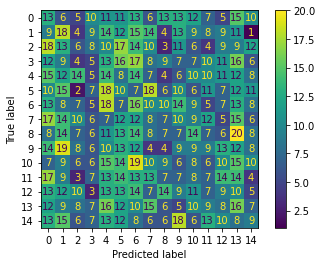

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


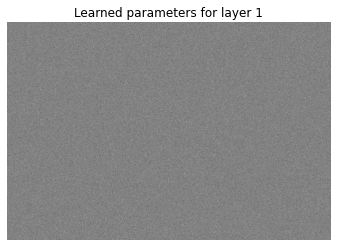

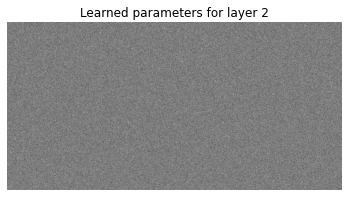

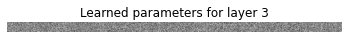

In [ ]:
#Experiment6
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease and an increase validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't prone to predict class any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7095
Validation Loss at epoch 0: 2.7997
In epoch: 1
Training Loss in this epoch: 2.7651
Validation Loss at epoch 1: 2.7924
In epoch: 2
Training Loss in this epoch: 2.6025
Validation Loss at epoch 2: 2.7568
In epoch: 3
Training Loss in this epoch: 2.5723
Validation Loss at epoch 3: 2.7334
In epoch: 4
Training Loss in this epoch: 2.5884
Validation Loss at epoch 4: 2.7280
In epoch: 5
Training Loss in this epoch: 2.7689
Validation Loss at epoch 5: 2.7272
In epoch: 6
Training Loss in this epoch: 2.5763
Validation Loss at epoch 6: 2.7271
In epoch: 7
Training Loss in this epoch: 2.7615
Validation Loss at epoch 7: 2.7271
In epoch: 8
Training Loss in this epoch: 2.6832
Validation Loss at epoch 8: 2.7271
In epoch: 9
Training Loss in this epoch: 2.6009
Validation Loss at epoch 9: 2.7271
In epoch: 10
Training Loss in this epoch: 2.4875
Validation Loss at epoch 10: 2.7271
Early stopping at epoch 10


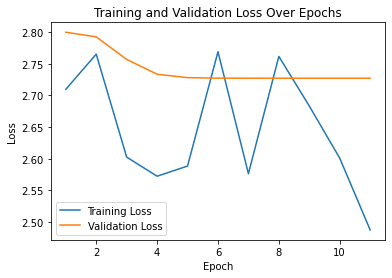

Test Accuracy: 7.47%
Test Precision: 0.0740
Test Recall: 0.0747
Test F1-Measure: 0.0735
Confusion Matrix:


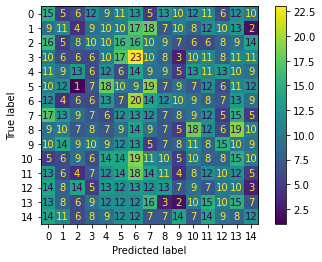

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


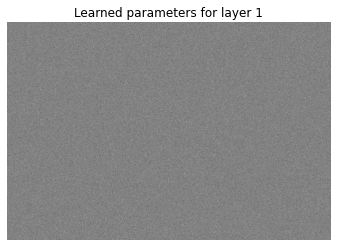

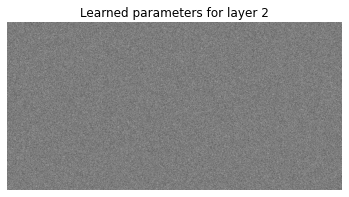

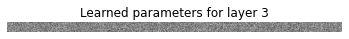

In [ ]:
#Experiment7
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and  a decrease, , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 6(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6826
Validation Loss at epoch 0: 2.8164
In epoch: 1
Training Loss in this epoch: 2.6749
Validation Loss at epoch 1: 2.8161
In epoch: 2
Training Loss in this epoch: 2.6941
Validation Loss at epoch 2: 2.7908
In epoch: 3
Training Loss in this epoch: 2.5153
Validation Loss at epoch 3: 2.7480
In epoch: 4
Training Loss in this epoch: 2.7109
Validation Loss at epoch 4: 2.7357
In epoch: 5
Training Loss in this epoch: 2.6631
Validation Loss at epoch 5: 2.7323
In epoch: 6
Training Loss in this epoch: 2.5305
Validation Loss at epoch 6: 2.7319
In epoch: 7
Training Loss in this epoch: 2.6027
Validation Loss at epoch 7: 2.7319
In epoch: 8
Training Loss in this epoch: 2.5193
Validation Loss at epoch 8: 2.7319
In epoch: 9
Training Loss in this epoch: 2.5869
Validation Loss at epoch 9: 2.7319
In epoch: 10
Training Loss in this epoch: 2.6206
Validation Loss at epoch 10: 2.7319
Early stopping at epoch 10


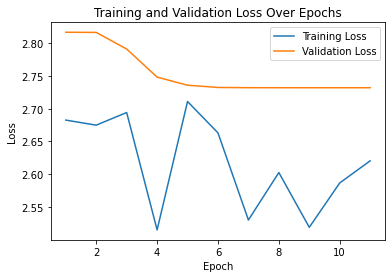

Test Accuracy: 7.20%
Test Precision: 0.0718
Test Recall: 0.0720
Test F1-Measure: 0.0705
Confusion Matrix:


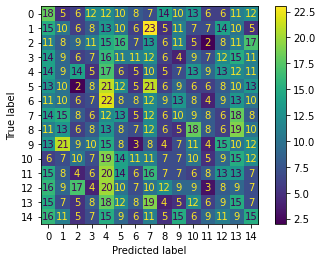

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


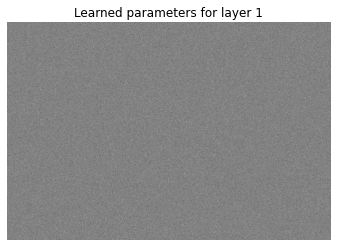

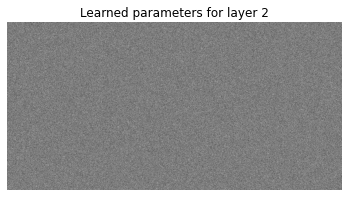

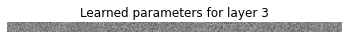

In [ ]:
#Experiment8
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and  a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 5 and 8(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.4851
Validation Loss at epoch 0: 2.8131
In epoch: 1
Training Loss in this epoch: 2.8442
Validation Loss at epoch 1: 2.7885
In epoch: 2
Training Loss in this epoch: 2.4756
Validation Loss at epoch 2: 2.7588
In epoch: 3
Training Loss in this epoch: 2.7079
Validation Loss at epoch 3: 2.7445
In epoch: 4
Training Loss in this epoch: 2.2270
Validation Loss at epoch 4: 2.7400
In epoch: 5
Training Loss in this epoch: 2.6738
Validation Loss at epoch 5: 2.7394
In epoch: 6
Training Loss in this epoch: 2.4947
Validation Loss at epoch 6: 2.7394
In epoch: 7
Training Loss in this epoch: 2.5309
Validation Loss at epoch 7: 2.7394
In epoch: 8
Training Loss in this epoch: 2.7070
Validation Loss at epoch 8: 2.7394
In epoch: 9
Training Loss in this epoch: 2.5987
Validation Loss at epoch 9: 2.7394
In epoch: 10
Training Loss in this epoch: 2.4361
Validation Loss at epoch 10: 2.7394
Early stopping at epoch 10


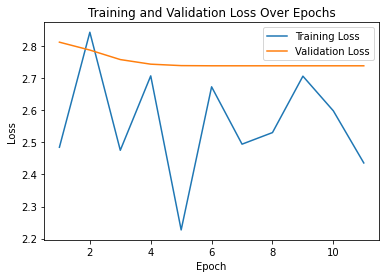

Test Accuracy: 7.20%
Test Precision: 0.0721
Test Recall: 0.0720
Test F1-Measure: 0.0713
Confusion Matrix:


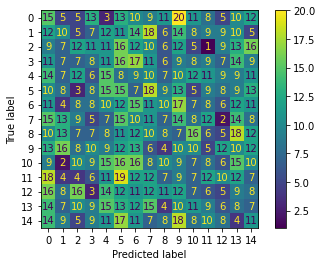

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


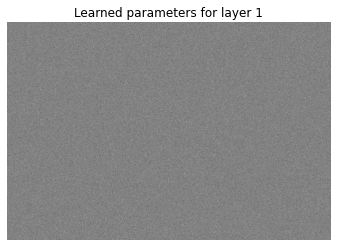

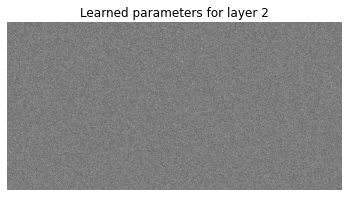

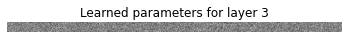

In [ ]:
#Experiment9
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and a decrease then an increase , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't prone to predict class any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.4582
Validation Loss at epoch 0: 2.8056
In epoch: 1
Training Loss in this epoch: 2.4921
Validation Loss at epoch 1: 2.8842
In epoch: 2
Training Loss in this epoch: 2.5288
Validation Loss at epoch 2: 2.7865
In epoch: 3
Training Loss in this epoch: 2.8118
Validation Loss at epoch 3: 2.7553
In epoch: 4
Training Loss in this epoch: 2.4670
Validation Loss at epoch 4: 2.7486
In epoch: 5
Training Loss in this epoch: 2.4425
Validation Loss at epoch 5: 2.7479
In epoch: 6
Training Loss in this epoch: 2.5614
Validation Loss at epoch 6: 2.7479
In epoch: 7
Training Loss in this epoch: 2.5307
Validation Loss at epoch 7: 2.7479
In epoch: 8
Training Loss in this epoch: 2.5942
Validation Loss at epoch 8: 2.7479
In epoch: 9
Training Loss in this epoch: 2.5219
Validation Loss at epoch 9: 2.7479
In epoch: 10
Training Loss in this epoch: 2.3304
Validation Loss at epoch 10: 2.7479
Early stopping at epoch 10


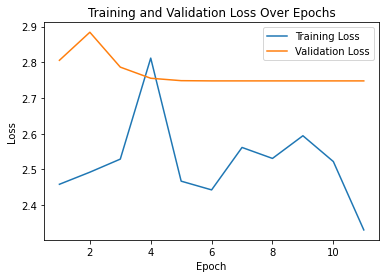

Test Accuracy: 7.16%
Test Precision: 0.0717
Test Recall: 0.0716
Test F1-Measure: 0.0709
Confusion Matrix:


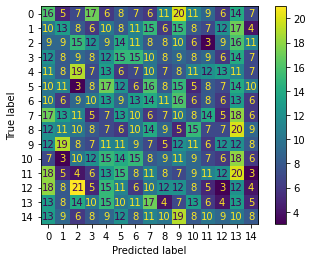

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


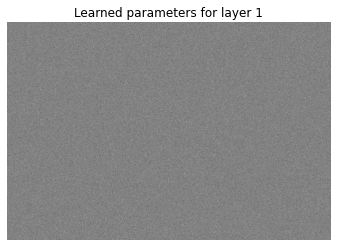

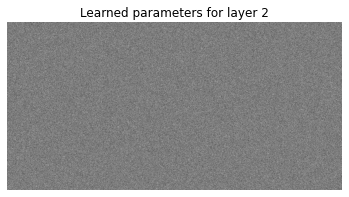

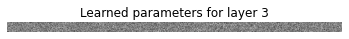

In [ ]:
#Experiment10
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and  a decrease, , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 3 and 14(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7755
Validation Loss at epoch 0: 2.8862
In epoch: 1
Training Loss in this epoch: 2.2202
Validation Loss at epoch 1: 2.9043
In epoch: 2
Training Loss in this epoch: 2.8079
Validation Loss at epoch 2: 2.8395
In epoch: 3
Training Loss in this epoch: 2.3786
Validation Loss at epoch 3: 2.7686
In epoch: 4
Training Loss in this epoch: 2.5433
Validation Loss at epoch 4: 2.7621
In epoch: 5
Training Loss in this epoch: 2.4258
Validation Loss at epoch 5: 2.7593
In epoch: 6
Training Loss in this epoch: 2.4833
Validation Loss at epoch 6: 2.7592
In epoch: 7
Training Loss in this epoch: 2.5833
Validation Loss at epoch 7: 2.7592
In epoch: 8
Training Loss in this epoch: 2.4644
Validation Loss at epoch 8: 2.7592
In epoch: 9
Training Loss in this epoch: 2.5606
Validation Loss at epoch 9: 2.7592
In epoch: 10
Training Loss in this epoch: 2.7167
Validation Loss at epoch 10: 2.7592
Early stopping at epoch 10


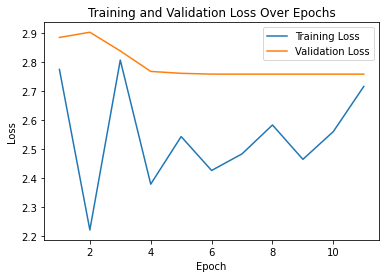

Test Accuracy: 7.02%
Test Precision: 0.0712
Test Recall: 0.0702
Test F1-Measure: 0.0700
Confusion Matrix:


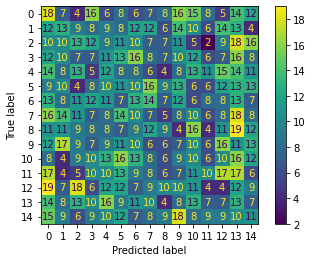

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


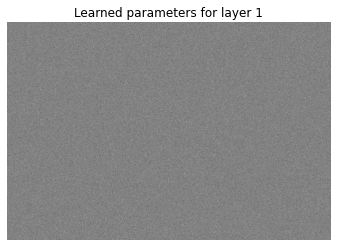

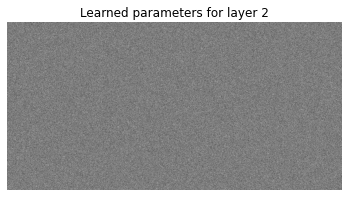

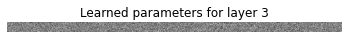

In [ ]:
#Experiment11
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and a decresase , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't prone to predict class any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6401
Validation Loss at epoch 0: 3.0115
In epoch: 1
Training Loss in this epoch: 2.3560
Validation Loss at epoch 1: 2.9277
In epoch: 2
Training Loss in this epoch: 2.4442
Validation Loss at epoch 2: 2.8684
In epoch: 3
Training Loss in this epoch: 2.7728
Validation Loss at epoch 3: 2.7905
In epoch: 4
Training Loss in this epoch: 2.6853
Validation Loss at epoch 4: 2.7786
In epoch: 5
Training Loss in this epoch: 2.6762
Validation Loss at epoch 5: 2.7736
In epoch: 6
Training Loss in this epoch: 2.3262
Validation Loss at epoch 6: 2.7736
In epoch: 7
Training Loss in this epoch: 2.4629
Validation Loss at epoch 7: 2.7735
In epoch: 8
Training Loss in this epoch: 2.4395
Validation Loss at epoch 8: 2.7735
In epoch: 9
Training Loss in this epoch: 2.5001
Validation Loss at epoch 9: 2.7735
In epoch: 10
Training Loss in this epoch: 2.4134
Validation Loss at epoch 10: 2.7735
Early stopping at epoch 10


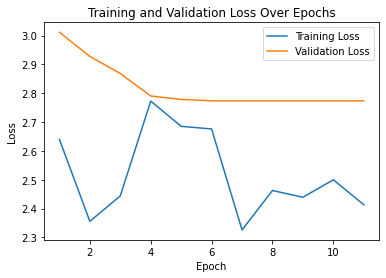

Test Accuracy: 7.07%
Test Precision: 0.0710
Test Recall: 0.0707
Test F1-Measure: 0.0703
Confusion Matrix:


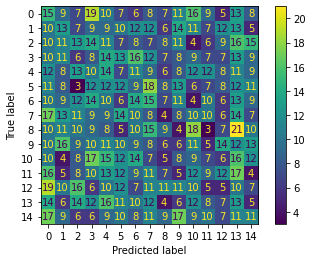

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


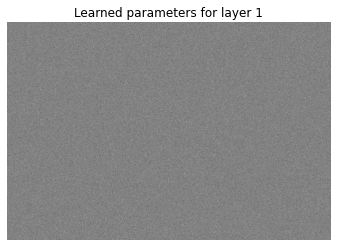

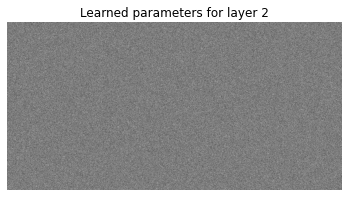

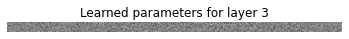

In [ ]:
#Experiment12
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 14(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.3742
Validation Loss at epoch 0: 2.9159
In epoch: 1
Training Loss in this epoch: 2.7423
Validation Loss at epoch 1: 2.8603
In epoch: 2
Training Loss in this epoch: 2.8220
Validation Loss at epoch 2: 2.8777
In epoch: 3
Training Loss in this epoch: 2.3090
Validation Loss at epoch 3: 2.8052
In epoch: 4
Training Loss in this epoch: 2.9143
Validation Loss at epoch 4: 2.7975
In epoch: 5
Training Loss in this epoch: 2.7208
Validation Loss at epoch 5: 2.7967
In epoch: 6
Training Loss in this epoch: 2.1781
Validation Loss at epoch 6: 2.7966
In epoch: 7
Training Loss in this epoch: 2.5602
Validation Loss at epoch 7: 2.7966
In epoch: 8
Training Loss in this epoch: 2.3691
Validation Loss at epoch 8: 2.7966
In epoch: 9
Training Loss in this epoch: 2.2078
Validation Loss at epoch 9: 2.7966
In epoch: 10
Training Loss in this epoch: 2.4662
Validation Loss at epoch 10: 2.7966
Early stopping at epoch 10


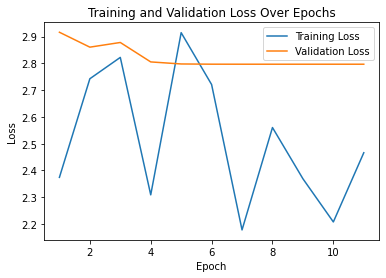

Test Accuracy: 7.24%
Test Precision: 0.0729
Test Recall: 0.0724
Test F1-Measure: 0.0721
Confusion Matrix:


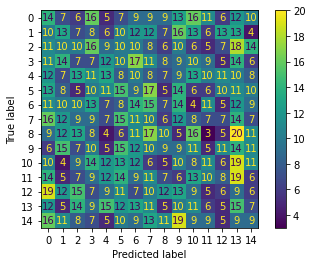

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


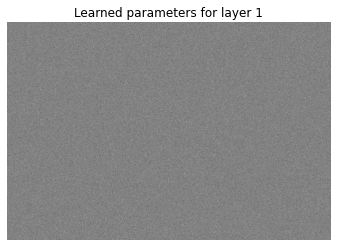

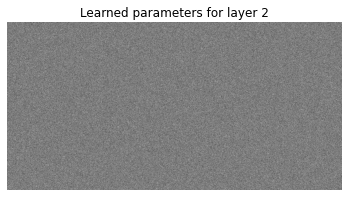

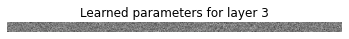

In [ ]:
#Experiment13
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 14(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5763
Validation Loss at epoch 0: 2.8258
In epoch: 1
Training Loss in this epoch: 2.4766
Validation Loss at epoch 1: 2.8838
In epoch: 2
Training Loss in this epoch: 2.6151
Validation Loss at epoch 2: 2.9048
In epoch: 3
Training Loss in this epoch: 2.4812
Validation Loss at epoch 3: 2.8291
In epoch: 4
Training Loss in this epoch: 2.1402
Validation Loss at epoch 4: 2.8248
In epoch: 5
Training Loss in this epoch: 2.4512
Validation Loss at epoch 5: 2.8227
In epoch: 6
Training Loss in this epoch: 2.0893
Validation Loss at epoch 6: 2.8224
In epoch: 7
Training Loss in this epoch: 2.1268
Validation Loss at epoch 7: 2.8224
In epoch: 8
Training Loss in this epoch: 2.8100
Validation Loss at epoch 8: 2.8224
In epoch: 9
Training Loss in this epoch: 2.2949
Validation Loss at epoch 9: 2.8224
In epoch: 10
Training Loss in this epoch: 2.6196
Validation Loss at epoch 10: 2.8224
Early stopping at epoch 10


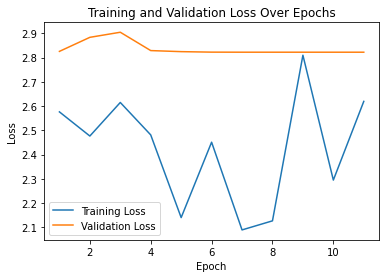

Test Accuracy: 7.16%
Test Precision: 0.0722
Test Recall: 0.0716
Test F1-Measure: 0.0714
Confusion Matrix:


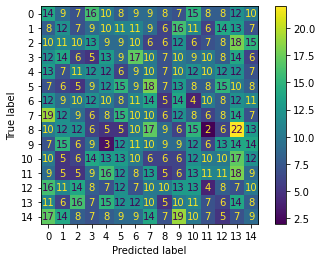

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


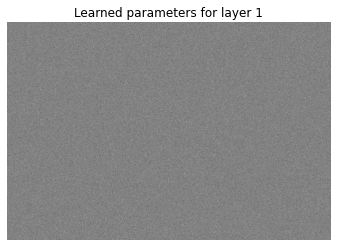

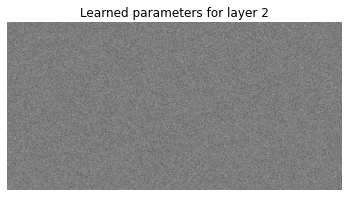

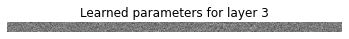

In [ ]:
#Experiment14
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase , validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.
Confusion matrix shows that this model is did prone to predict class 14(class names starts from 0 in the confusion matrix) more than other classes.


In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6330
Validation Loss at epoch 0: 2.9017
In epoch: 1
Training Loss in this epoch: 2.3092
Validation Loss at epoch 1: 2.9688
In epoch: 2
Training Loss in this epoch: 2.5467
Validation Loss at epoch 2: 2.9359
In epoch: 3
Training Loss in this epoch: 2.3321
Validation Loss at epoch 3: 2.8780
In epoch: 4
Training Loss in this epoch: 2.4495
Validation Loss at epoch 4: 2.8580
In epoch: 5
Training Loss in this epoch: 2.3830
Validation Loss at epoch 5: 2.8559
In epoch: 6
Training Loss in this epoch: 2.5536
Validation Loss at epoch 6: 2.8557
In epoch: 7
Training Loss in this epoch: 2.6039
Validation Loss at epoch 7: 2.8557
In epoch: 8
Training Loss in this epoch: 2.2361
Validation Loss at epoch 8: 2.8557
In epoch: 9
Training Loss in this epoch: 2.2266
Validation Loss at epoch 9: 2.8557
In epoch: 10
Training Loss in this epoch: 2.1098
Validation Loss at epoch 10: 2.8557
Early stopping at epoch 10


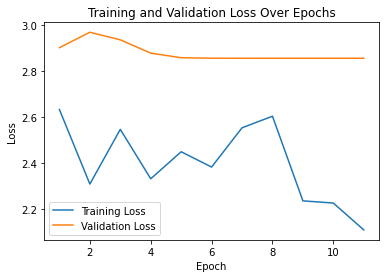

Test Accuracy: 7.20%
Test Precision: 0.0726
Test Recall: 0.0720
Test F1-Measure: 0.0720
Confusion Matrix:


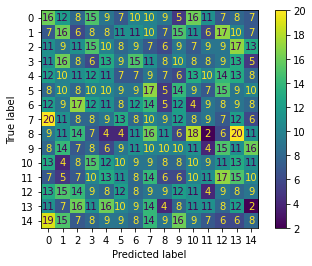

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


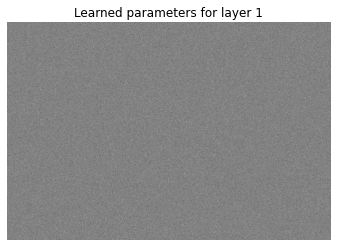

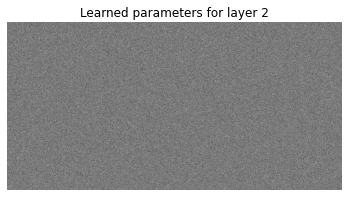

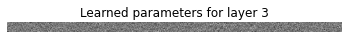

In [ ]:
#Experiment15
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase , validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is didn't particularly prone to predict class any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5984
Validation Loss at epoch 0: 3.0723
In epoch: 1
Training Loss in this epoch: 2.0345
Validation Loss at epoch 1: 3.2458
In epoch: 2
Training Loss in this epoch: 2.2966
Validation Loss at epoch 2: 2.9791
In epoch: 3
Training Loss in this epoch: 2.6116
Validation Loss at epoch 3: 2.9516
In epoch: 4
Training Loss in this epoch: 2.4605
Validation Loss at epoch 4: 2.9233
In epoch: 5
Training Loss in this epoch: 2.2228
Validation Loss at epoch 5: 2.9049
In epoch: 6
Training Loss in this epoch: 1.9408
Validation Loss at epoch 6: 2.9010
In epoch: 7
Training Loss in this epoch: 2.1636
Validation Loss at epoch 7: 2.9005
In epoch: 8
Training Loss in this epoch: 2.1824
Validation Loss at epoch 8: 2.9005
In epoch: 9
Training Loss in this epoch: 2.0681
Validation Loss at epoch 9: 2.9005
In epoch: 10
Training Loss in this epoch: 1.7571
Validation Loss at epoch 10: 2.9005
Early stopping at epoch 10


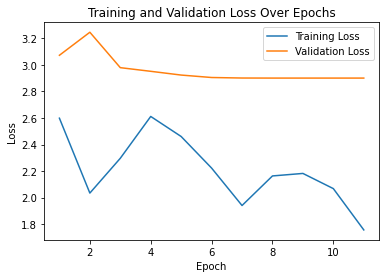

Test Accuracy: 7.42%
Test Precision: 0.0749
Test Recall: 0.0742
Test F1-Measure: 0.0744
Confusion Matrix:


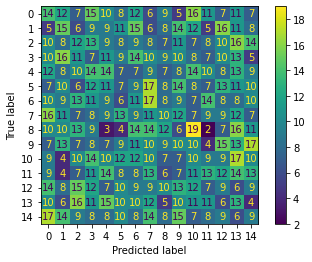

Parameters for layer 1 shape: (1076, 1600)
Parameters for layer 2 shape: (538, 1076)
Parameters for layer 3 shape: (15, 538)


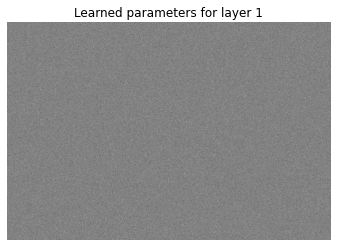

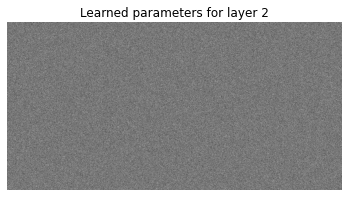

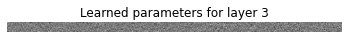

In [ ]:
#Experiment16
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase , validation error didn't continue to decrease after epoch 3. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 3.

Confusion matrix shows that this model is didn't particularly prone to predict class any class more than other classes.

## Creating Second Model

In [ ]:
#This model has 1 hidden layer
number_of_hidden_layers = 1

In [ ]:
#CREATING LAYER UNIT SIZE LIST
# number of units is calculated mean sizes for each hidden layer
no_units = return_number_of_hidden_layer_units(number_of_hidden_layers,number_of_input_parameter)
print(no_units)

# layer size is a list of number of units in each layer [input hidden1 ... hiddenn output]
layer_sizes = [number_of_input_parameter]
for i in no_units:
    layer_sizes.append(i)
layer_sizes.append(15)
print(layer_sizes)


[807]
[1600, 807, 15]


In [ ]:
#CREATING ACTIVATION LIST
# List of Activation functions for each hidden layer and output layer
activations = []
for i in range(number_of_hidden_layers):
    activations.append("relu")
activations.append("softmax")
print(activations)

['relu', 'softmax']


In [ ]:
#Set initial weights for W and b
initial_parameters_W, initial_parameters_b = initialize_parameters(layer_sizes, activations)

### Experiment on Second Model 

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7549
Validation Loss at epoch 0: 3.0716
In epoch: 1
Training Loss in this epoch: 2.7908
Validation Loss at epoch 1: 2.9475
In epoch: 2
Training Loss in this epoch: 2.7193
Validation Loss at epoch 2: 2.7684
In epoch: 3
Training Loss in this epoch: 2.6446
Validation Loss at epoch 3: 2.7268
In epoch: 4
Training Loss in this epoch: 2.8340
Validation Loss at epoch 4: 2.7223
In epoch: 5
Training Loss in this epoch: 2.7853
Validation Loss at epoch 5: 2.7220
In epoch: 6
Training Loss in this epoch: 2.6629
Validation Loss at epoch 6: 2.7219
In epoch: 7
Training Loss in this epoch: 2.7079
Validation Loss at epoch 7: 2.7219
In epoch: 8
Training Loss in this epoch: 2.7229
Validation Loss at epoch 8: 2.7219
In epoch: 9
Training Loss in this epoch: 2.6266
Validation Loss at epoch 9: 2.7219
In epoch: 10
Training Loss in this epoch: 2.6024
Validation Loss at epoch 10: 2.7219
Early stopping at epoch 10


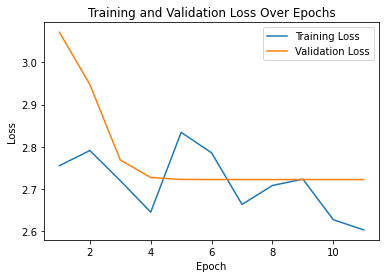

Test Accuracy: 6.58%
Test Precision: 0.0697
Test Recall: 0.0658
Test F1-Measure: 0.0656
Confusion Matrix:


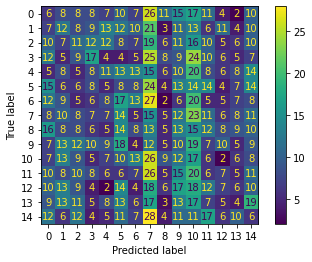

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


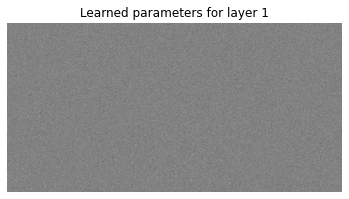

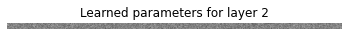

In [ ]:
#Experiment17
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is did prone to predict class 8(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7577
Validation Loss at epoch 0: 2.9643
In epoch: 1
Training Loss in this epoch: 2.9605
Validation Loss at epoch 1: 2.7935
In epoch: 2
Training Loss in this epoch: 2.6460
Validation Loss at epoch 2: 2.8248
In epoch: 3
Training Loss in this epoch: 2.7401
Validation Loss at epoch 3: 2.7291
In epoch: 4
Training Loss in this epoch: 2.6257
Validation Loss at epoch 4: 2.7227
In epoch: 5
Training Loss in this epoch: 2.7358
Validation Loss at epoch 5: 2.7222
In epoch: 6
Training Loss in this epoch: 2.6563
Validation Loss at epoch 6: 2.7221
In epoch: 7
Training Loss in this epoch: 2.8128
Validation Loss at epoch 7: 2.7221
In epoch: 8
Training Loss in this epoch: 2.7457
Validation Loss at epoch 8: 2.7221
In epoch: 9
Training Loss in this epoch: 2.6116
Validation Loss at epoch 9: 2.7221
In epoch: 10
Training Loss in this epoch: 2.6598
Validation Loss at epoch 10: 2.7221
Early stopping at epoch 10


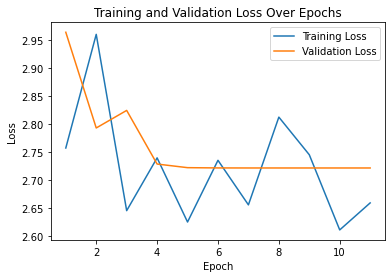

Test Accuracy: 6.49%
Test Precision: 0.0628
Test Recall: 0.0649
Test F1-Measure: 0.0606
Confusion Matrix:


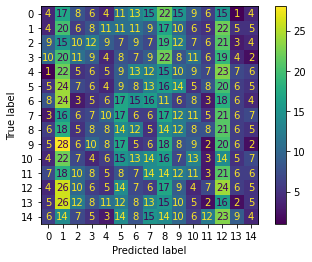

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


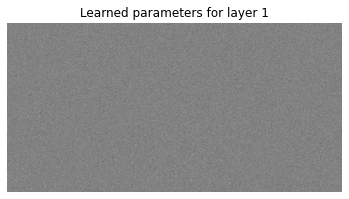

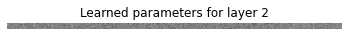

In [ ]:
#Experiment18
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease and an increase, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model did prone to predict class 2 and 13(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6814
Validation Loss at epoch 0: 2.8052
In epoch: 1
Training Loss in this epoch: 2.6120
Validation Loss at epoch 1: 2.9426
In epoch: 2
Training Loss in this epoch: 2.7210
Validation Loss at epoch 2: 2.7917
In epoch: 3
Training Loss in this epoch: 2.7694
Validation Loss at epoch 3: 2.7409
In epoch: 4
Training Loss in this epoch: 2.7002
Validation Loss at epoch 4: 2.7236
In epoch: 5
Training Loss in this epoch: 2.6223
Validation Loss at epoch 5: 2.7233
In epoch: 6
Training Loss in this epoch: 2.7584
Validation Loss at epoch 6: 2.7232
In epoch: 7
Training Loss in this epoch: 2.7169
Validation Loss at epoch 7: 2.7232
In epoch: 8
Training Loss in this epoch: 2.6918
Validation Loss at epoch 8: 2.7232
In epoch: 9
Training Loss in this epoch: 2.6507
Validation Loss at epoch 9: 2.7232
In epoch: 10
Training Loss in this epoch: 2.7231
Validation Loss at epoch 10: 2.7232
Early stopping at epoch 10


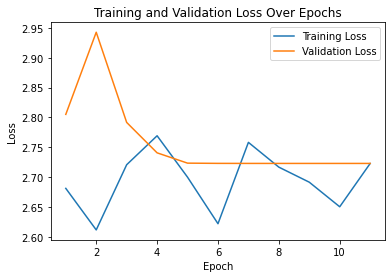

Test Accuracy: 6.76%
Test Precision: 0.0671
Test Recall: 0.0676
Test F1-Measure: 0.0651
Confusion Matrix:


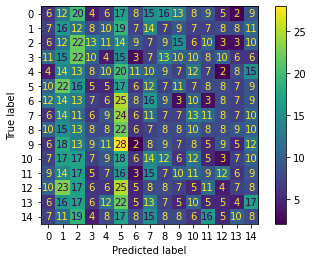

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


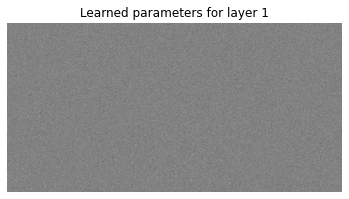

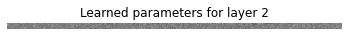

In [ ]:
#Experiment19
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is prone to predict class 6(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5346
Validation Loss at epoch 0: 2.9480
In epoch: 1
Training Loss in this epoch: 2.7565
Validation Loss at epoch 1: 2.8611
In epoch: 2
Training Loss in this epoch: 2.5810
Validation Loss at epoch 2: 2.7875
In epoch: 3
Training Loss in this epoch: 2.6617
Validation Loss at epoch 3: 2.7497
In epoch: 4
Training Loss in this epoch: 2.6374
Validation Loss at epoch 4: 2.7266
In epoch: 5
Training Loss in this epoch: 2.7330
Validation Loss at epoch 5: 2.7239
In epoch: 6
Training Loss in this epoch: 2.7203
Validation Loss at epoch 6: 2.7239
In epoch: 7
Training Loss in this epoch: 2.7706
Validation Loss at epoch 7: 2.7238
In epoch: 8
Training Loss in this epoch: 2.6294
Validation Loss at epoch 8: 2.7238
In epoch: 9
Training Loss in this epoch: 2.7207
Validation Loss at epoch 9: 2.7238
In epoch: 10
Training Loss in this epoch: 2.6911
Validation Loss at epoch 10: 2.7238
Early stopping at epoch 10


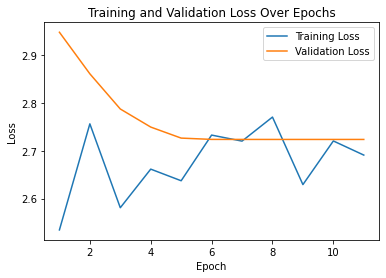

Test Accuracy: 6.89%
Test Precision: 0.0705
Test Recall: 0.0689
Test F1-Measure: 0.0679
Confusion Matrix:


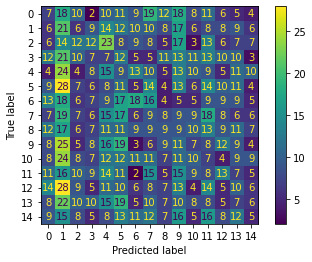

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


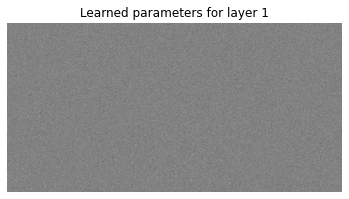

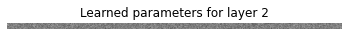

In [ ]:
#Experiment20
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease and an increase, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is prone to predict class 2(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6917
Validation Loss at epoch 0: 2.8458
In epoch: 1
Training Loss in this epoch: 2.6602
Validation Loss at epoch 1: 2.9421
In epoch: 2
Training Loss in this epoch: 2.5820
Validation Loss at epoch 2: 2.7849
In epoch: 3
Training Loss in this epoch: 2.6342
Validation Loss at epoch 3: 2.7297
In epoch: 4
Training Loss in this epoch: 2.5648
Validation Loss at epoch 4: 2.7257
In epoch: 5
Training Loss in this epoch: 2.5770
Validation Loss at epoch 5: 2.7256
In epoch: 6
Training Loss in this epoch: 2.5588
Validation Loss at epoch 6: 2.7256
In epoch: 7
Training Loss in this epoch: 2.7130
Validation Loss at epoch 7: 2.7256
In epoch: 8
Training Loss in this epoch: 2.7090
Validation Loss at epoch 8: 2.7256
In epoch: 9
Training Loss in this epoch: 2.7746
Validation Loss at epoch 9: 2.7256
In epoch: 10
Training Loss in this epoch: 2.5550
Validation Loss at epoch 10: 2.7256
Early stopping at epoch 10


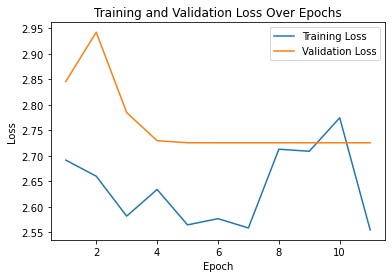

Test Accuracy: 7.47%
Test Precision: 0.0773
Test Recall: 0.0747
Test F1-Measure: 0.0744
Confusion Matrix:


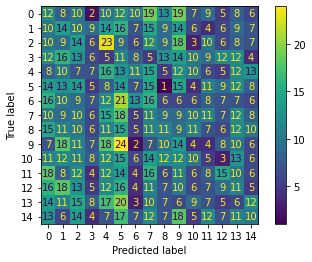

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


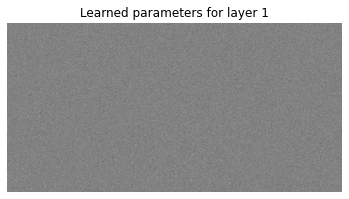

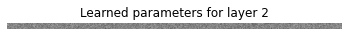

In [ ]:
#Experiment21
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is prone to predict class 6(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5586
Validation Loss at epoch 0: 2.8858
In epoch: 1
Training Loss in this epoch: 2.7401
Validation Loss at epoch 1: 2.8828
In epoch: 2
Training Loss in this epoch: 2.6329
Validation Loss at epoch 2: 2.7692
In epoch: 3
Training Loss in this epoch: 2.6693
Validation Loss at epoch 3: 2.7324
In epoch: 4
Training Loss in this epoch: 2.5129
Validation Loss at epoch 4: 2.7282
In epoch: 5
Training Loss in this epoch: 2.7114
Validation Loss at epoch 5: 2.7280
In epoch: 6
Training Loss in this epoch: 2.6025
Validation Loss at epoch 6: 2.7279
In epoch: 7
Training Loss in this epoch: 2.7447
Validation Loss at epoch 7: 2.7279
In epoch: 8
Training Loss in this epoch: 2.4861
Validation Loss at epoch 8: 2.7279
In epoch: 9
Training Loss in this epoch: 2.5688
Validation Loss at epoch 9: 2.7279
In epoch: 10
Training Loss in this epoch: 2.5766
Validation Loss at epoch 10: 2.7279
Early stopping at epoch 10


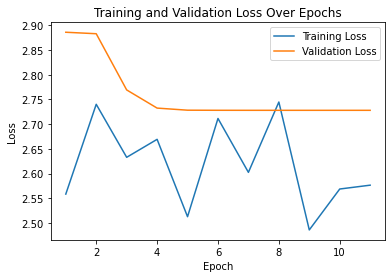

Test Accuracy: 7.24%
Test Precision: 0.0744
Test Recall: 0.0724
Test F1-Measure: 0.0715
Confusion Matrix:


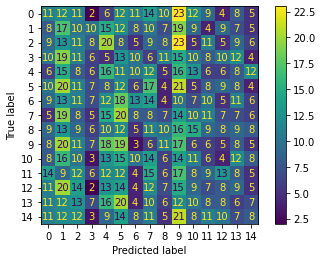

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


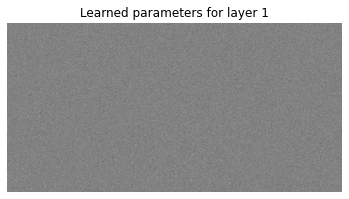

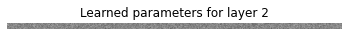

In [ ]:
#Experiment22
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.
Confusion matrix shows that this model is  prone to predict class 10(class names starts from 0 in the confusion matrix) more than other classes.


In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7424
Validation Loss at epoch 0: 2.8604
In epoch: 1
Training Loss in this epoch: 2.6180
Validation Loss at epoch 1: 2.8729
In epoch: 2
Training Loss in this epoch: 2.6214
Validation Loss at epoch 2: 2.7558
In epoch: 3
Training Loss in this epoch: 2.8209
Validation Loss at epoch 3: 2.7359
In epoch: 4
Training Loss in this epoch: 2.6492
Validation Loss at epoch 4: 2.7320
In epoch: 5
Training Loss in this epoch: 2.4836
Validation Loss at epoch 5: 2.7307
In epoch: 6
Training Loss in this epoch: 2.5464
Validation Loss at epoch 6: 2.7306
In epoch: 7
Training Loss in this epoch: 2.6870
Validation Loss at epoch 7: 2.7306
In epoch: 8
Training Loss in this epoch: 2.6878
Validation Loss at epoch 8: 2.7306
In epoch: 9
Training Loss in this epoch: 2.5157
Validation Loss at epoch 9: 2.7306
In epoch: 10
Training Loss in this epoch: 2.7028
Validation Loss at epoch 10: 2.7306
Early stopping at epoch 10


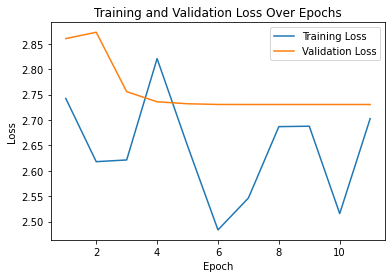

Test Accuracy: 7.33%
Test Precision: 0.0748
Test Recall: 0.0733
Test F1-Measure: 0.0731
Confusion Matrix:


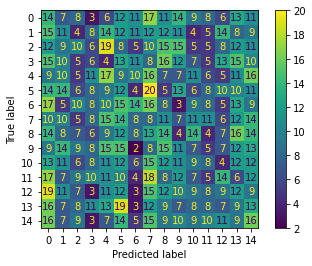

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


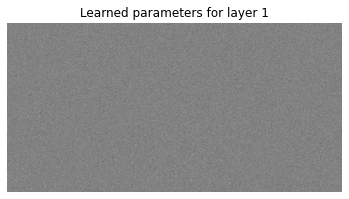

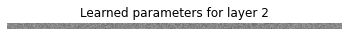

In [ ]:
#Experiment23
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7683
Validation Loss at epoch 0: 2.9084
In epoch: 1
Training Loss in this epoch: 2.7675
Validation Loss at epoch 1: 2.9031
In epoch: 2
Training Loss in this epoch: 2.4487
Validation Loss at epoch 2: 2.7691
In epoch: 3
Training Loss in this epoch: 2.8773
Validation Loss at epoch 3: 2.7620
In epoch: 4
Training Loss in this epoch: 2.4791
Validation Loss at epoch 4: 2.7375
In epoch: 5
Training Loss in this epoch: 2.7870
Validation Loss at epoch 5: 2.7335
In epoch: 6
Training Loss in this epoch: 2.6982
Validation Loss at epoch 6: 2.7334
In epoch: 7
Training Loss in this epoch: 2.5986
Validation Loss at epoch 7: 2.7333
In epoch: 8
Training Loss in this epoch: 2.7993
Validation Loss at epoch 8: 2.7333
In epoch: 9
Training Loss in this epoch: 2.6358
Validation Loss at epoch 9: 2.7333
In epoch: 10
Training Loss in this epoch: 2.7586
Validation Loss at epoch 10: 2.7333
Early stopping at epoch 10


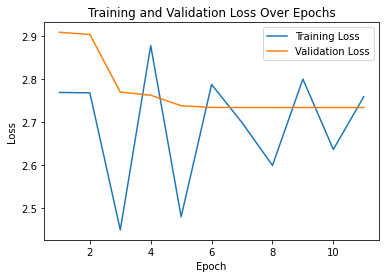

Test Accuracy: 7.42%
Test Precision: 0.0744
Test Recall: 0.0742
Test F1-Measure: 0.0733
Confusion Matrix:


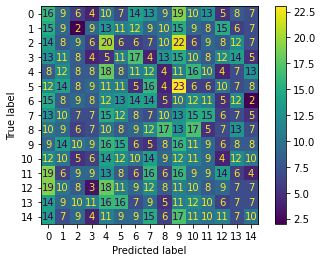

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


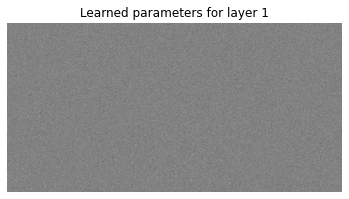

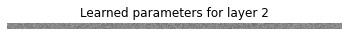

In [ ]:
#Experiment24
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is  prone to predict class 10(class names starts from 0 in the confusion matrix) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 3.0590
Validation Loss at epoch 0: 2.8602
In epoch: 1
Training Loss in this epoch: 2.5506
Validation Loss at epoch 1: 2.8590
In epoch: 2
Training Loss in this epoch: 2.8448
Validation Loss at epoch 2: 2.7513
In epoch: 3
Training Loss in this epoch: 2.6226
Validation Loss at epoch 3: 2.7458
In epoch: 4
Training Loss in this epoch: 2.5304
Validation Loss at epoch 4: 2.7384
In epoch: 5
Training Loss in this epoch: 2.4583
Validation Loss at epoch 5: 2.7379
In epoch: 6
Training Loss in this epoch: 2.6529
Validation Loss at epoch 6: 2.7378
In epoch: 7
Training Loss in this epoch: 2.4951
Validation Loss at epoch 7: 2.7378
In epoch: 8
Training Loss in this epoch: 2.8192
Validation Loss at epoch 8: 2.7378
In epoch: 9
Training Loss in this epoch: 2.7138
Validation Loss at epoch 9: 2.7378
In epoch: 10
Training Loss in this epoch: 2.3048
Validation Loss at epoch 10: 2.7378
Early stopping at epoch 10


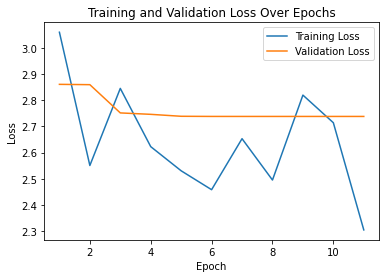

Test Accuracy: 7.29%
Test Precision: 0.0719
Test Recall: 0.0729
Test F1-Measure: 0.0715
Confusion Matrix:


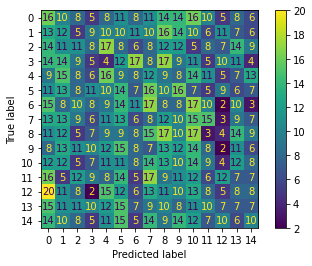

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


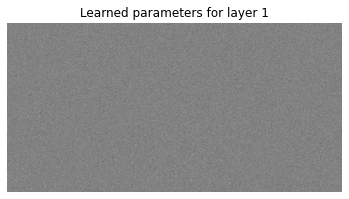

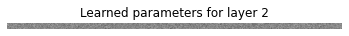

In [ ]:
#Experiment25
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 3. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 3.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.8591
Validation Loss at epoch 0: 2.8219
In epoch: 1
Training Loss in this epoch: 2.6809
Validation Loss at epoch 1: 2.8843
In epoch: 2
Training Loss in this epoch: 2.7035
Validation Loss at epoch 2: 2.7877
In epoch: 3
Training Loss in this epoch: 2.6861
Validation Loss at epoch 3: 2.7474
In epoch: 4
Training Loss in this epoch: 2.8435
Validation Loss at epoch 4: 2.7435
In epoch: 5
Training Loss in this epoch: 2.8092
Validation Loss at epoch 5: 2.7429
In epoch: 6
Training Loss in this epoch: 2.6317
Validation Loss at epoch 6: 2.7429
In epoch: 7
Training Loss in this epoch: 2.6254
Validation Loss at epoch 7: 2.7429
In epoch: 8
Training Loss in this epoch: 2.4371
Validation Loss at epoch 8: 2.7429
In epoch: 9
Training Loss in this epoch: 2.5337
Validation Loss at epoch 9: 2.7429
In epoch: 10
Training Loss in this epoch: 2.5606
Validation Loss at epoch 10: 2.7429
Early stopping at epoch 10


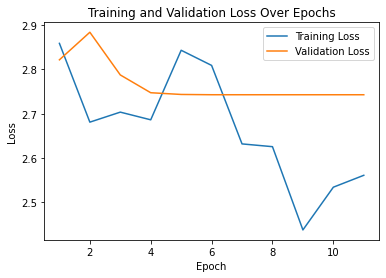

Test Accuracy: 7.24%
Test Precision: 0.0728
Test Recall: 0.0724
Test F1-Measure: 0.0721
Confusion Matrix:


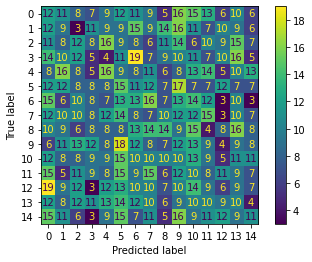

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


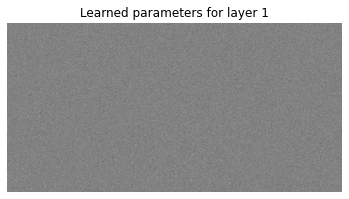

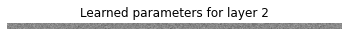

In [ ]:
#Experiment26
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5325
Validation Loss at epoch 0: 2.9716
In epoch: 1
Training Loss in this epoch: 2.5455
Validation Loss at epoch 1: 2.9788
In epoch: 2
Training Loss in this epoch: 2.3698
Validation Loss at epoch 2: 2.7938
In epoch: 3
Training Loss in this epoch: 2.7326
Validation Loss at epoch 3: 2.7594
In epoch: 4
Training Loss in this epoch: 2.7743
Validation Loss at epoch 4: 2.7512
In epoch: 5
Training Loss in this epoch: 2.5097
Validation Loss at epoch 5: 2.7487
In epoch: 6
Training Loss in this epoch: 2.5736
Validation Loss at epoch 6: 2.7487
In epoch: 7
Training Loss in this epoch: 2.5203
Validation Loss at epoch 7: 2.7487
In epoch: 8
Training Loss in this epoch: 2.4621
Validation Loss at epoch 8: 2.7487
In epoch: 9
Training Loss in this epoch: 2.4560
Validation Loss at epoch 9: 2.7487
In epoch: 10
Training Loss in this epoch: 2.7621
Validation Loss at epoch 10: 2.7487
Early stopping at epoch 10


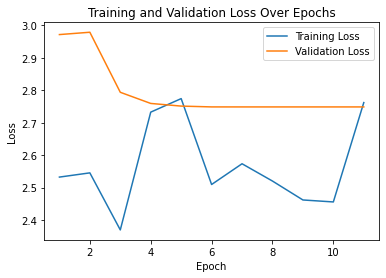

Test Accuracy: 7.11%
Test Precision: 0.0719
Test Recall: 0.0711
Test F1-Measure: 0.0708
Confusion Matrix:


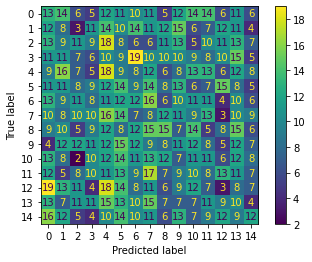

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


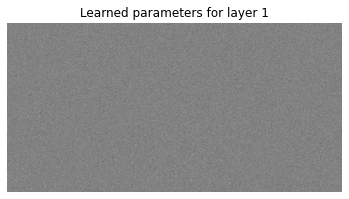

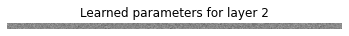

In [ ]:
#Experiment27
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.8262
Validation Loss at epoch 0: 2.8105
In epoch: 1
Training Loss in this epoch: 2.9368
Validation Loss at epoch 1: 2.8287
In epoch: 2
Training Loss in this epoch: 2.7490
Validation Loss at epoch 2: 2.8624
In epoch: 3
Training Loss in this epoch: 2.6201
Validation Loss at epoch 3: 2.7750
In epoch: 4
Training Loss in this epoch: 2.4909
Validation Loss at epoch 4: 2.7617
In epoch: 5
Training Loss in this epoch: 2.7292
Validation Loss at epoch 5: 2.7553
In epoch: 6
Training Loss in this epoch: 2.5126
Validation Loss at epoch 6: 2.7550
In epoch: 7
Training Loss in this epoch: 2.8183
Validation Loss at epoch 7: 2.7550
In epoch: 8
Training Loss in this epoch: 2.7167
Validation Loss at epoch 8: 2.7550
In epoch: 9
Training Loss in this epoch: 2.5316
Validation Loss at epoch 9: 2.7550
In epoch: 10
Training Loss in this epoch: 2.4432
Validation Loss at epoch 10: 2.7550
Early stopping at epoch 10


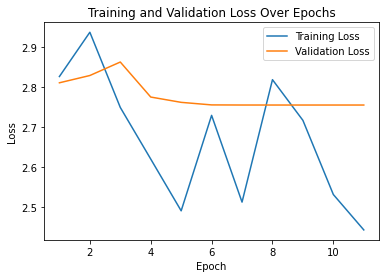

Test Accuracy: 7.42%
Test Precision: 0.0750
Test Recall: 0.0742
Test F1-Measure: 0.0743
Confusion Matrix:


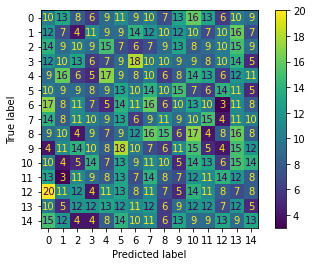

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


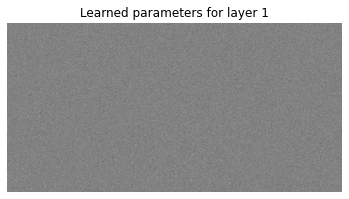

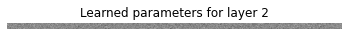

In [ ]:
#Experiment28
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5306
Validation Loss at epoch 0: 2.9090
In epoch: 1
Training Loss in this epoch: 2.9707
Validation Loss at epoch 1: 2.8337
In epoch: 2
Training Loss in this epoch: 2.7393
Validation Loss at epoch 2: 2.8158
In epoch: 3
Training Loss in this epoch: 2.4695
Validation Loss at epoch 3: 2.7766
In epoch: 4
Training Loss in this epoch: 2.6491
Validation Loss at epoch 4: 2.7685
In epoch: 5
Training Loss in this epoch: 2.7421
Validation Loss at epoch 5: 2.7658
In epoch: 6
Training Loss in this epoch: 2.7953
Validation Loss at epoch 6: 2.7657
In epoch: 7
Training Loss in this epoch: 2.6921
Validation Loss at epoch 7: 2.7656
In epoch: 8
Training Loss in this epoch: 2.6104
Validation Loss at epoch 8: 2.7656
In epoch: 9
Training Loss in this epoch: 2.4694
Validation Loss at epoch 9: 2.7656
In epoch: 10
Training Loss in this epoch: 2.4594
Validation Loss at epoch 10: 2.7656
Early stopping at epoch 10


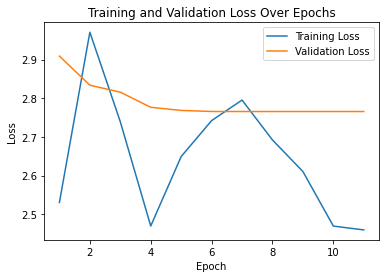

Test Accuracy: 7.24%
Test Precision: 0.0744
Test Recall: 0.0724
Test F1-Measure: 0.0729
Confusion Matrix:


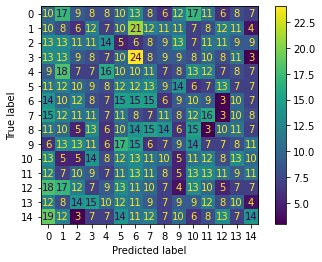

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


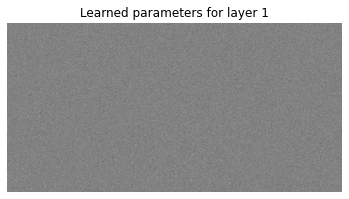

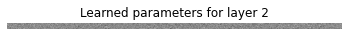

In [ ]:
#Experiment29
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.9137
Validation Loss at epoch 0: 2.9446
In epoch: 1
Training Loss in this epoch: 2.4402
Validation Loss at epoch 1: 2.9613
In epoch: 2
Training Loss in this epoch: 2.5347
Validation Loss at epoch 2: 2.8422
In epoch: 3
Training Loss in this epoch: 2.7647
Validation Loss at epoch 3: 2.7812
In epoch: 4
Training Loss in this epoch: 2.5851
Validation Loss at epoch 4: 2.7775
In epoch: 5
Training Loss in this epoch: 2.6602
Validation Loss at epoch 5: 2.7754
In epoch: 6
Training Loss in this epoch: 2.5323
Validation Loss at epoch 6: 2.7753
In epoch: 7
Training Loss in this epoch: 2.6997
Validation Loss at epoch 7: 2.7753
In epoch: 8
Training Loss in this epoch: 2.6842
Validation Loss at epoch 8: 2.7753
In epoch: 9
Training Loss in this epoch: 2.7122
Validation Loss at epoch 9: 2.7753
In epoch: 10
Training Loss in this epoch: 2.3985
Validation Loss at epoch 10: 2.7753
Early stopping at epoch 10


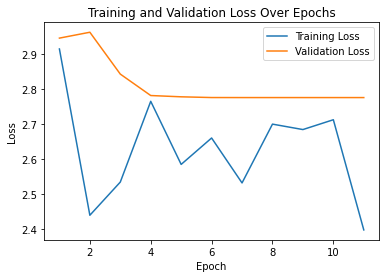

Test Accuracy: 7.11%
Test Precision: 0.0728
Test Recall: 0.0711
Test F1-Measure: 0.0717
Confusion Matrix:


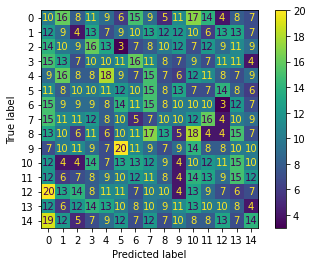

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


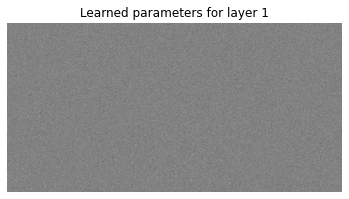

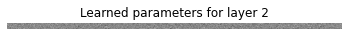

In [ ]:
#Experiment30
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7456
Validation Loss at epoch 0: 2.8764
In epoch: 1
Training Loss in this epoch: 2.6128
Validation Loss at epoch 1: 2.9925
In epoch: 2
Training Loss in this epoch: 2.8569
Validation Loss at epoch 2: 2.8498
In epoch: 3
Training Loss in this epoch: 2.6815
Validation Loss at epoch 3: 2.7940
In epoch: 4
Training Loss in this epoch: 2.0651
Validation Loss at epoch 4: 2.7916
In epoch: 5
Training Loss in this epoch: 2.5059
Validation Loss at epoch 5: 2.7861
In epoch: 6
Training Loss in this epoch: 2.6021
Validation Loss at epoch 6: 2.7856
In epoch: 7
Training Loss in this epoch: 2.5070
Validation Loss at epoch 7: 2.7856
In epoch: 8
Training Loss in this epoch: 2.7615
Validation Loss at epoch 8: 2.7856
In epoch: 9
Training Loss in this epoch: 2.6610
Validation Loss at epoch 9: 2.7856
In epoch: 10
Training Loss in this epoch: 2.5924
Validation Loss at epoch 10: 2.7856
Early stopping at epoch 10


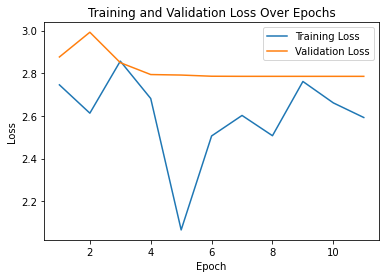

Test Accuracy: 6.98%
Test Precision: 0.0711
Test Recall: 0.0698
Test F1-Measure: 0.0701
Confusion Matrix:


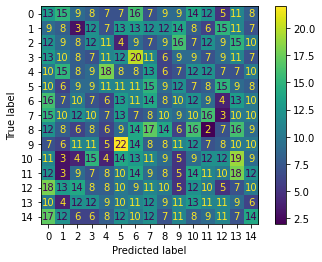

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


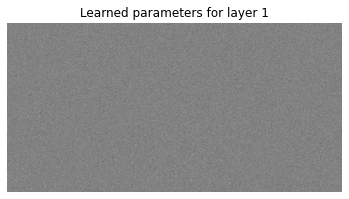

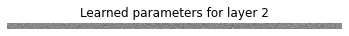

In [ ]:
#Experiment31
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease, an increase and then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.1498
Validation Loss at epoch 0: 2.9225
In epoch: 1
Training Loss in this epoch: 2.7463
Validation Loss at epoch 1: 2.9425
In epoch: 2
Training Loss in this epoch: 2.6828
Validation Loss at epoch 2: 2.9009
In epoch: 3
Training Loss in this epoch: 2.6019
Validation Loss at epoch 3: 2.8174
In epoch: 4
Training Loss in this epoch: 2.4934
Validation Loss at epoch 4: 2.8048
In epoch: 5
Training Loss in this epoch: 2.4011
Validation Loss at epoch 5: 2.7985
In epoch: 6
Training Loss in this epoch: 2.4355
Validation Loss at epoch 6: 2.7975
In epoch: 7
Training Loss in this epoch: 2.1146
Validation Loss at epoch 7: 2.7973
In epoch: 8
Training Loss in this epoch: 2.4455
Validation Loss at epoch 8: 2.7973
In epoch: 9
Training Loss in this epoch: 2.6894
Validation Loss at epoch 9: 2.7973
In epoch: 10
Training Loss in this epoch: 2.3839
Validation Loss at epoch 10: 2.7973
Early stopping at epoch 10


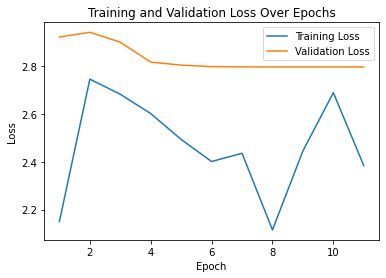

Test Accuracy: 6.93%
Test Precision: 0.0701
Test Recall: 0.0693
Test F1-Measure: 0.0695
Confusion Matrix:


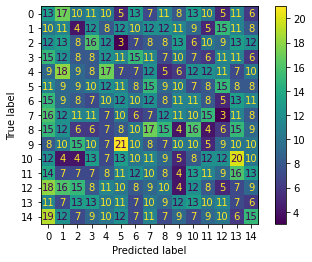

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


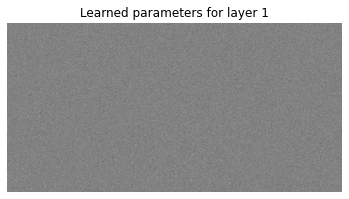

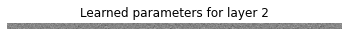

In [ ]:
#Experiment32
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is didn't particularly prone to predict any class more than other classes.

##  Creating third Model

In [ ]:
# This model has one hidden layer
number_of_hidden_layers = 1

In [ ]:
#CREATING LAYER UNIT SIZE LIST
# number of units is calculated mean sizes for each hidden layer
no_units = return_number_of_hidden_layer_units(number_of_hidden_layers,number_of_input_parameter)
print(no_units)

# layer size is a list of number of units in each layer [input hidden1 ... hiddenn output]
layer_sizes = [number_of_input_parameter]
for i in no_units:
    layer_sizes.append(i)
layer_sizes.append(15)
print(layer_sizes)


[807]
[1600, 807, 15]


In [ ]:
# This model will use sigmoid activation function in hidden layer
#CREATING ACTIVATION LIST
# List of Activation functions for each hidden layer and output layer
activations = []
for i in range(number_of_hidden_layers):
    activations.append("sigmoid")
activations.append("softmax")
print(activations)

['sigmoid', 'softmax']


In [ ]:
initial_parameters_W, initial_parameters_b = initialize_parameters(layer_sizes, activations)

### Experiments on third Model

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6713
Validation Loss at epoch 0: 2.9779
In epoch: 1
Training Loss in this epoch: 2.7351
Validation Loss at epoch 1: 2.9717
In epoch: 2
Training Loss in this epoch: 2.7052
Validation Loss at epoch 2: 2.7396
In epoch: 3
Training Loss in this epoch: 2.6674
Validation Loss at epoch 3: 2.7152
In epoch: 4
Training Loss in this epoch: 2.7121
Validation Loss at epoch 4: 2.7096
In epoch: 5
Training Loss in this epoch: 2.7066
Validation Loss at epoch 5: 2.7092
In epoch: 6
Training Loss in this epoch: 2.7569
Validation Loss at epoch 6: 2.7092
In epoch: 7
Training Loss in this epoch: 2.7308
Validation Loss at epoch 7: 2.7092
In epoch: 8
Training Loss in this epoch: 2.7553
Validation Loss at epoch 8: 2.7092
In epoch: 9
Training Loss in this epoch: 2.6572
Validation Loss at epoch 9: 2.7092
In epoch: 10
Training Loss in this epoch: 2.6745
Validation Loss at epoch 10: 2.7092
Early stopping at epoch 10


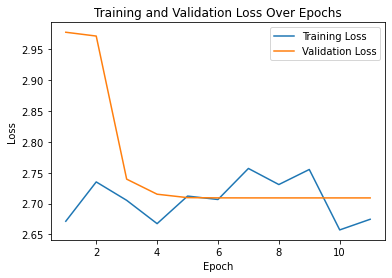

Test Accuracy: 7.07%
Test Precision: 0.1339
Test Recall: 0.0707
Test F1-Measure: 0.0466
Confusion Matrix:


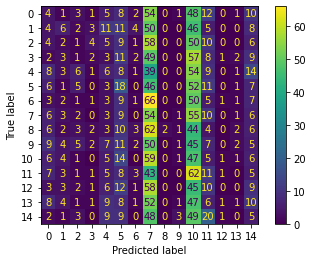

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


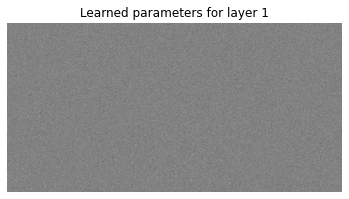

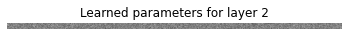

In [ ]:
#Experiment33
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease until epoch 4, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 8 and 11(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6549
Validation Loss at epoch 0: 2.8511
In epoch: 1
Training Loss in this epoch: 2.8472
Validation Loss at epoch 1: 2.8090
In epoch: 2
Training Loss in this epoch: 2.6095
Validation Loss at epoch 2: 2.8092
In epoch: 3
Training Loss in this epoch: 2.7021
Validation Loss at epoch 3: 2.7152
In epoch: 4
Training Loss in this epoch: 2.6497
Validation Loss at epoch 4: 2.7095
In epoch: 5
Training Loss in this epoch: 2.7342
Validation Loss at epoch 5: 2.7090
In epoch: 6
Training Loss in this epoch: 2.7328
Validation Loss at epoch 6: 2.7090
In epoch: 7
Training Loss in this epoch: 2.7406
Validation Loss at epoch 7: 2.7090
In epoch: 8
Training Loss in this epoch: 2.7105
Validation Loss at epoch 8: 2.7090
In epoch: 9
Training Loss in this epoch: 2.6738
Validation Loss at epoch 9: 2.7090
In epoch: 10
Training Loss in this epoch: 2.7317
Validation Loss at epoch 10: 2.7090
Early stopping at epoch 10


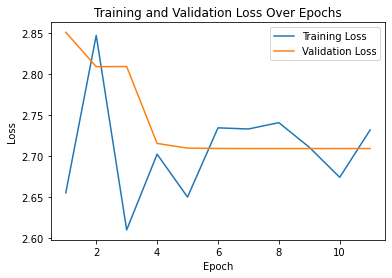

Test Accuracy: 6.76%
Test Precision: 0.0830
Test Recall: 0.0676
Test F1-Measure: 0.0465
Confusion Matrix:


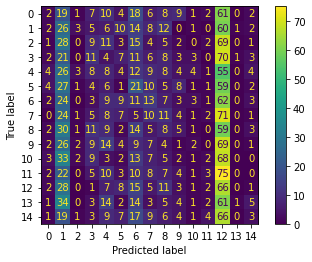

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


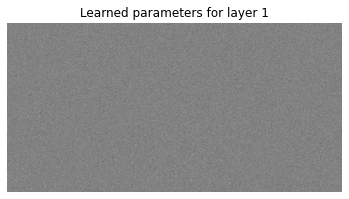

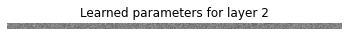

In [ ]:
#Experiment34
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase then a decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 13(class names startes from 0) much more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7467
Validation Loss at epoch 0: 2.8200
In epoch: 1
Training Loss in this epoch: 2.7011
Validation Loss at epoch 1: 2.8400
In epoch: 2
Training Loss in this epoch: 2.7515
Validation Loss at epoch 2: 2.8161
In epoch: 3
Training Loss in this epoch: 2.6865
Validation Loss at epoch 3: 2.7230
In epoch: 4
Training Loss in this epoch: 2.6888
Validation Loss at epoch 4: 2.7095
In epoch: 5
Training Loss in this epoch: 2.6641
Validation Loss at epoch 5: 2.7092
In epoch: 6
Training Loss in this epoch: 2.7176
Validation Loss at epoch 6: 2.7091
In epoch: 7
Training Loss in this epoch: 2.7072
Validation Loss at epoch 7: 2.7090
In epoch: 8
Training Loss in this epoch: 2.6750
Validation Loss at epoch 8: 2.7090
In epoch: 9
Training Loss in this epoch: 2.6809
Validation Loss at epoch 9: 2.7090
In epoch: 10
Training Loss in this epoch: 2.6874
Validation Loss at epoch 10: 2.7090
Early stopping at epoch 10


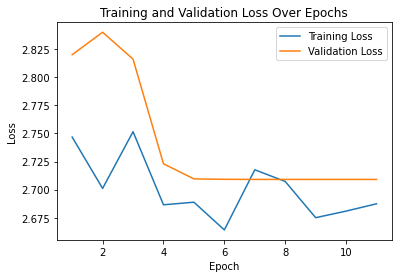

Test Accuracy: 6.89%
Test Precision: 0.0687
Test Recall: 0.0689
Test F1-Measure: 0.0549
Confusion Matrix:


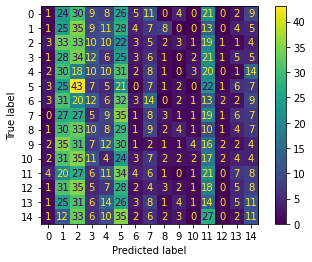

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


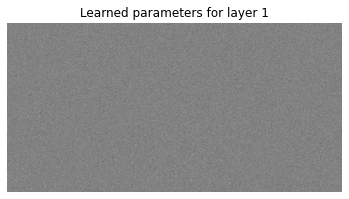

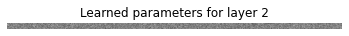

In [ ]:
#Experiment35
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease after epoch 3, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 2,3,6,12(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5968
Validation Loss at epoch 0: 2.8531
In epoch: 1
Training Loss in this epoch: 2.7569
Validation Loss at epoch 1: 2.8262
In epoch: 2
Training Loss in this epoch: 2.6877
Validation Loss at epoch 2: 2.7683
In epoch: 3
Training Loss in this epoch: 2.6927
Validation Loss at epoch 3: 2.7267
In epoch: 4
Training Loss in this epoch: 2.6562
Validation Loss at epoch 4: 2.7110
In epoch: 5
Training Loss in this epoch: 2.7488
Validation Loss at epoch 5: 2.7092
In epoch: 6
Training Loss in this epoch: 2.6803
Validation Loss at epoch 6: 2.7091
In epoch: 7
Training Loss in this epoch: 2.7205
Validation Loss at epoch 7: 2.7091
In epoch: 8
Training Loss in this epoch: 2.6487
Validation Loss at epoch 8: 2.7091
In epoch: 9
Training Loss in this epoch: 2.7037
Validation Loss at epoch 9: 2.7091
In epoch: 10
Training Loss in this epoch: 2.7295
Validation Loss at epoch 10: 2.7091
Early stopping at epoch 10


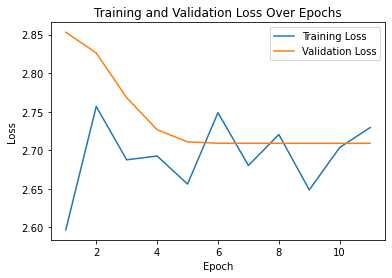

Test Accuracy: 7.24%
Test Precision: 0.0768
Test Recall: 0.0724
Test F1-Measure: 0.0632
Confusion Matrix:


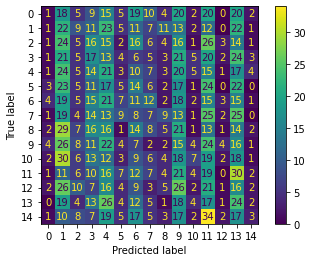

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


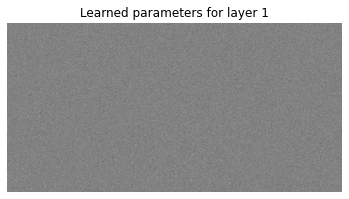

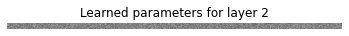

In [ ]:
#Experiment36
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=128 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)


While training error shows an increase then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 2(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5914
Validation Loss at epoch 0: 2.8728
In epoch: 1
Training Loss in this epoch: 2.6245
Validation Loss at epoch 1: 2.9839
In epoch: 2
Training Loss in this epoch: 2.6525
Validation Loss at epoch 2: 2.7799
In epoch: 3
Training Loss in this epoch: 2.7651
Validation Loss at epoch 3: 2.7132
In epoch: 4
Training Loss in this epoch: 2.6771
Validation Loss at epoch 4: 2.7098
In epoch: 5
Training Loss in this epoch: 2.6646
Validation Loss at epoch 5: 2.7096
In epoch: 6
Training Loss in this epoch: 2.7059
Validation Loss at epoch 6: 2.7096
In epoch: 7
Training Loss in this epoch: 2.7905
Validation Loss at epoch 7: 2.7096
In epoch: 8
Training Loss in this epoch: 2.7139
Validation Loss at epoch 8: 2.7096
In epoch: 9
Training Loss in this epoch: 2.7301
Validation Loss at epoch 9: 2.7096
In epoch: 10
Training Loss in this epoch: 2.6798
Validation Loss at epoch 10: 2.7096
Early stopping at epoch 10


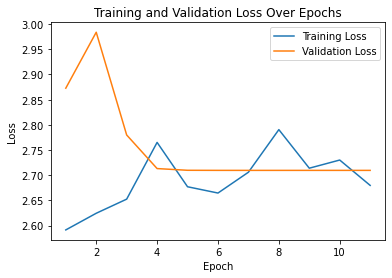

Test Accuracy: 7.16%
Test Precision: 0.0737
Test Recall: 0.0716
Test F1-Measure: 0.0628
Confusion Matrix:


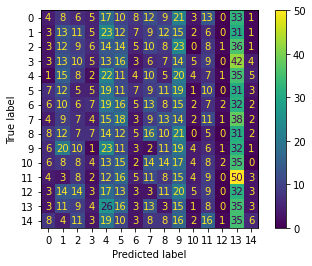

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


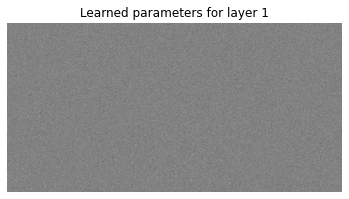

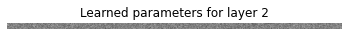

In [ ]:
#Experiment37
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and a decrease validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6911
Validation Loss at epoch 0: 2.8326
In epoch: 1
Training Loss in this epoch: 2.9372
Validation Loss at epoch 1: 2.8886
In epoch: 2
Training Loss in this epoch: 2.6745
Validation Loss at epoch 2: 2.7494
In epoch: 3
Training Loss in this epoch: 2.7469
Validation Loss at epoch 3: 2.7134
In epoch: 4
Training Loss in this epoch: 2.6249
Validation Loss at epoch 4: 2.7103
In epoch: 5
Training Loss in this epoch: 2.6888
Validation Loss at epoch 5: 2.7101
In epoch: 6
Training Loss in this epoch: 2.6946
Validation Loss at epoch 6: 2.7100
In epoch: 7
Training Loss in this epoch: 2.7180
Validation Loss at epoch 7: 2.7100
In epoch: 8
Training Loss in this epoch: 2.5633
Validation Loss at epoch 8: 2.7100
In epoch: 9
Training Loss in this epoch: 2.6956
Validation Loss at epoch 9: 2.7100
In epoch: 10
Training Loss in this epoch: 2.6916
Validation Loss at epoch 10: 2.7100
Early stopping at epoch 10


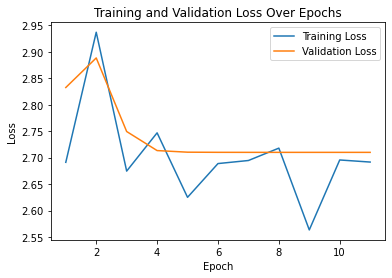

Test Accuracy: 6.62%
Test Precision: 0.0670
Test Recall: 0.0662
Test F1-Measure: 0.0531
Confusion Matrix:


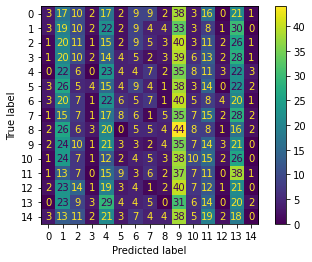

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


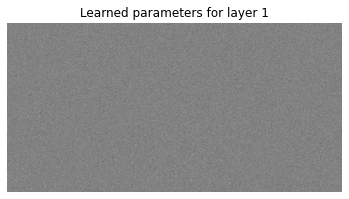

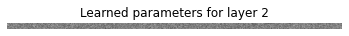

In [ ]:
#Experiment38
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and a  decrease, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 10 and 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6088
Validation Loss at epoch 0: 2.8405
In epoch: 1
Training Loss in this epoch: 2.7558
Validation Loss at epoch 1: 2.8187
In epoch: 2
Training Loss in this epoch: 2.7152
Validation Loss at epoch 2: 2.7499
In epoch: 3
Training Loss in this epoch: 2.7673
Validation Loss at epoch 3: 2.7184
In epoch: 4
Training Loss in this epoch: 2.6621
Validation Loss at epoch 4: 2.7122
In epoch: 5
Training Loss in this epoch: 2.6932
Validation Loss at epoch 5: 2.7104
In epoch: 6
Training Loss in this epoch: 2.6769
Validation Loss at epoch 6: 2.7103
In epoch: 7
Training Loss in this epoch: 2.7421
Validation Loss at epoch 7: 2.7103
In epoch: 8
Training Loss in this epoch: 2.6722
Validation Loss at epoch 8: 2.7103
In epoch: 9
Training Loss in this epoch: 2.6770
Validation Loss at epoch 9: 2.7103
In epoch: 10
Training Loss in this epoch: 2.6897
Validation Loss at epoch 10: 2.7103
Early stopping at epoch 10


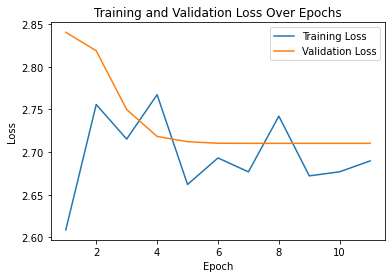

Test Accuracy: 7.47%
Test Precision: 0.0756
Test Recall: 0.0747
Test F1-Measure: 0.0623
Confusion Matrix:


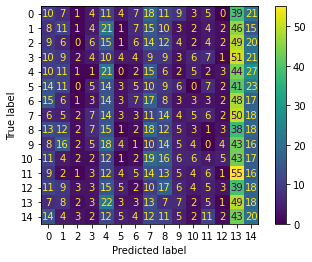

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


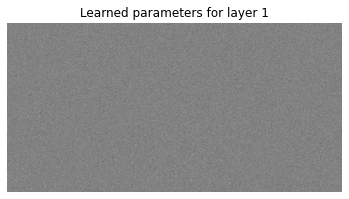

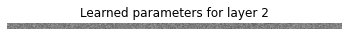

In [ ]:
#Experiment39
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 14 and 15(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7964
Validation Loss at epoch 0: 2.8232
In epoch: 1
Training Loss in this epoch: 2.6989
Validation Loss at epoch 1: 2.8396
In epoch: 2
Training Loss in this epoch: 2.6828
Validation Loss at epoch 2: 2.7652
In epoch: 3
Training Loss in this epoch: 2.7766
Validation Loss at epoch 3: 2.7298
In epoch: 4
Training Loss in this epoch: 2.6544
Validation Loss at epoch 4: 2.7137
In epoch: 5
Training Loss in this epoch: 2.7778
Validation Loss at epoch 5: 2.7108
In epoch: 6
Training Loss in this epoch: 2.6776
Validation Loss at epoch 6: 2.7105
In epoch: 7
Training Loss in this epoch: 2.7014
Validation Loss at epoch 7: 2.7105
In epoch: 8
Training Loss in this epoch: 2.7737
Validation Loss at epoch 8: 2.7105
In epoch: 9
Training Loss in this epoch: 2.6277
Validation Loss at epoch 9: 2.7105
In epoch: 10
Training Loss in this epoch: 2.6764
Validation Loss at epoch 10: 2.7105
Early stopping at epoch 10


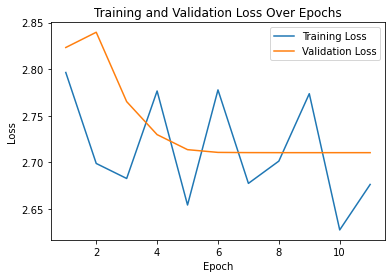

Test Accuracy: 6.84%
Test Precision: 0.0627
Test Recall: 0.0684
Test F1-Measure: 0.0568
Confusion Matrix:


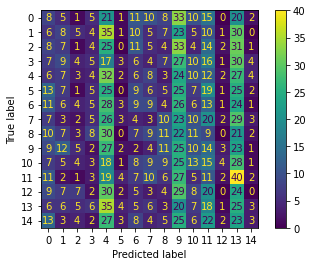

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


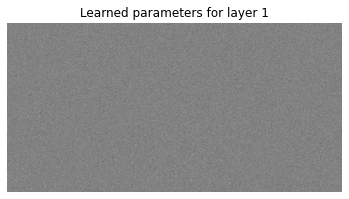

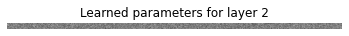

In [ ]:
#Experiment40
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=64 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)


While training error shows a decrease and an increase and a decrease, validation error didn't continue to decrease after epoch 6. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 6.

Confusion matrix shows that this model is proned to predict class 5,10,14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.8516
Validation Loss at epoch 0: 2.8280
In epoch: 1
Training Loss in this epoch: 2.6374
Validation Loss at epoch 1: 2.9835
In epoch: 2
Training Loss in this epoch: 2.8954
Validation Loss at epoch 2: 2.7353
In epoch: 3
Training Loss in this epoch: 2.7588
Validation Loss at epoch 3: 2.7182
In epoch: 4
Training Loss in this epoch: 2.7055
Validation Loss at epoch 4: 2.7117
In epoch: 5
Training Loss in this epoch: 2.6340
Validation Loss at epoch 5: 2.7110
In epoch: 6
Training Loss in this epoch: 2.7399
Validation Loss at epoch 6: 2.7110
In epoch: 7
Training Loss in this epoch: 2.6766
Validation Loss at epoch 7: 2.7110
In epoch: 8
Training Loss in this epoch: 2.7015
Validation Loss at epoch 8: 2.7110
In epoch: 9
Training Loss in this epoch: 2.6568
Validation Loss at epoch 9: 2.7110
In epoch: 10
Training Loss in this epoch: 2.6788
Validation Loss at epoch 10: 2.7110
Early stopping at epoch 10


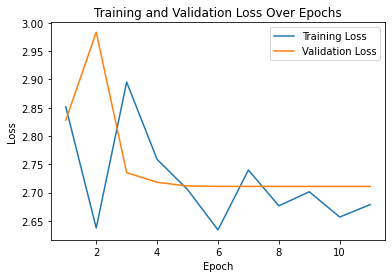

Test Accuracy: 6.71%
Test Precision: 0.0707
Test Recall: 0.0671
Test F1-Measure: 0.0589
Confusion Matrix:


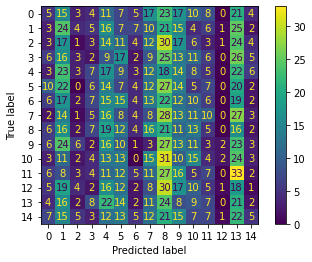

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


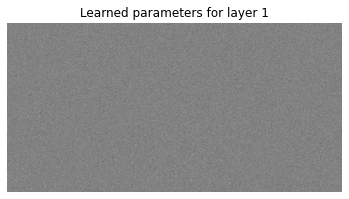

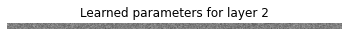

In [ ]:
#Experiment41
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease and an increase and then a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 2,9,14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.8785
Validation Loss at epoch 0: 2.8194
In epoch: 1
Training Loss in this epoch: 2.8733
Validation Loss at epoch 1: 2.8236
In epoch: 2
Training Loss in this epoch: 2.8018
Validation Loss at epoch 2: 2.7476
In epoch: 3
Training Loss in this epoch: 2.7359
Validation Loss at epoch 3: 2.7159
In epoch: 4
Training Loss in this epoch: 2.7054
Validation Loss at epoch 4: 2.7123
In epoch: 5
Training Loss in this epoch: 2.6865
Validation Loss at epoch 5: 2.7115
In epoch: 6
Training Loss in this epoch: 2.6892
Validation Loss at epoch 6: 2.7115
In epoch: 7
Training Loss in this epoch: 2.7657
Validation Loss at epoch 7: 2.7115
In epoch: 8
Training Loss in this epoch: 2.6795
Validation Loss at epoch 8: 2.7115
In epoch: 9
Training Loss in this epoch: 2.6727
Validation Loss at epoch 9: 2.7115
In epoch: 10
Training Loss in this epoch: 2.7028
Validation Loss at epoch 10: 2.7115
Early stopping at epoch 10


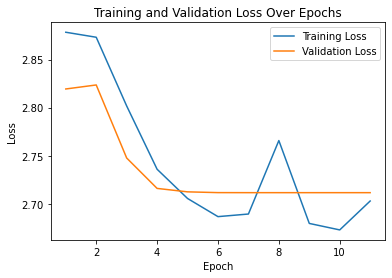

Test Accuracy: 6.62%
Test Precision: 0.0724
Test Recall: 0.0662
Test F1-Measure: 0.0623
Confusion Matrix:


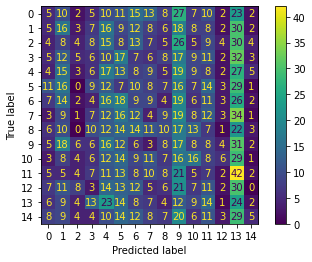

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


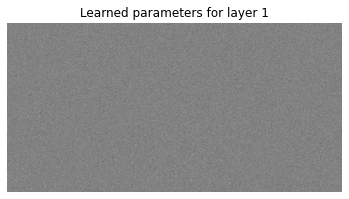

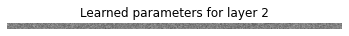

In [ ]:
#Experiment42
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7958
Validation Loss at epoch 0: 2.9589
In epoch: 1
Training Loss in this epoch: 2.5212
Validation Loss at epoch 1: 2.9005
In epoch: 2
Training Loss in this epoch: 2.6272
Validation Loss at epoch 2: 2.7647
In epoch: 3
Training Loss in this epoch: 2.7578
Validation Loss at epoch 3: 2.7243
In epoch: 4
Training Loss in this epoch: 2.7000
Validation Loss at epoch 4: 2.7154
In epoch: 5
Training Loss in this epoch: 2.6652
Validation Loss at epoch 5: 2.7121
In epoch: 6
Training Loss in this epoch: 2.6776
Validation Loss at epoch 6: 2.7120
In epoch: 7
Training Loss in this epoch: 2.6912
Validation Loss at epoch 7: 2.7120
In epoch: 8
Training Loss in this epoch: 2.6235
Validation Loss at epoch 8: 2.7120
In epoch: 9
Training Loss in this epoch: 2.5910
Validation Loss at epoch 9: 2.7120
In epoch: 10
Training Loss in this epoch: 2.7242
Validation Loss at epoch 10: 2.7120
Early stopping at epoch 10


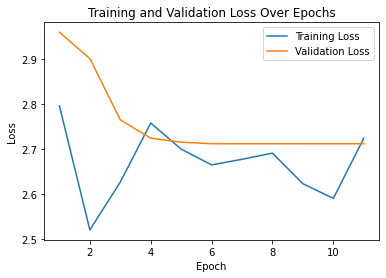

Test Accuracy: 6.80%
Test Precision: 0.0704
Test Recall: 0.0680
Test F1-Measure: 0.0607
Confusion Matrix:


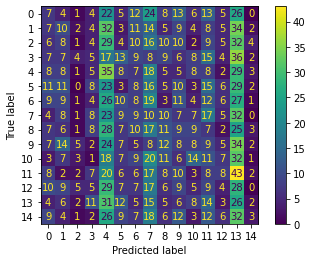

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


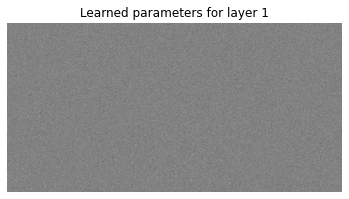

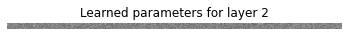

In [ ]:
#Experiment43
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)


While training error shows a decrease and a decrease and then stayed similar, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 14 and 5(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7888
Validation Loss at epoch 0: 2.8373
In epoch: 1
Training Loss in this epoch: 2.6758
Validation Loss at epoch 1: 2.8502
In epoch: 2
Training Loss in this epoch: 2.8150
Validation Loss at epoch 2: 2.8141
In epoch: 3
Training Loss in this epoch: 2.7497
Validation Loss at epoch 3: 2.7344
In epoch: 4
Training Loss in this epoch: 2.6436
Validation Loss at epoch 4: 2.7211
In epoch: 5
Training Loss in this epoch: 2.7019
Validation Loss at epoch 5: 2.7133
In epoch: 6
Training Loss in this epoch: 2.6970
Validation Loss at epoch 6: 2.7127
In epoch: 7
Training Loss in this epoch: 2.7329
Validation Loss at epoch 7: 2.7126
In epoch: 8
Training Loss in this epoch: 2.7224
Validation Loss at epoch 8: 2.7126
In epoch: 9
Training Loss in this epoch: 2.7256
Validation Loss at epoch 9: 2.7126
In epoch: 10
Training Loss in this epoch: 2.6653
Validation Loss at epoch 10: 2.7126
Early stopping at epoch 10


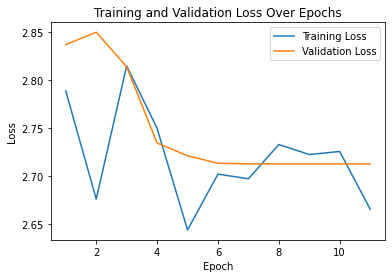

Test Accuracy: 6.89%
Test Precision: 0.0786
Test Recall: 0.0689
Test F1-Measure: 0.0666
Confusion Matrix:


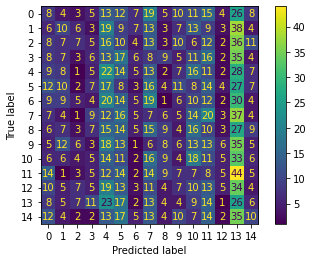

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


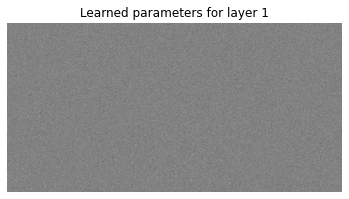

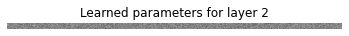

In [ ]:
#Experiment44
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=32 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error first decreased then increased and then decreased, validation error didn't continue to decrease after epoch 6. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 6.

Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7659
Validation Loss at epoch 0: 2.8386
In epoch: 1
Training Loss in this epoch: 3.0611
Validation Loss at epoch 1: 2.7790
In epoch: 2
Training Loss in this epoch: 2.7206
Validation Loss at epoch 2: 2.7493
In epoch: 3
Training Loss in this epoch: 2.7390
Validation Loss at epoch 3: 2.7270
In epoch: 4
Training Loss in this epoch: 2.7313
Validation Loss at epoch 4: 2.7161
In epoch: 5
Training Loss in this epoch: 2.7848
Validation Loss at epoch 5: 2.7136
In epoch: 6
Training Loss in this epoch: 2.7105
Validation Loss at epoch 6: 2.7135
In epoch: 7
Training Loss in this epoch: 2.7598
Validation Loss at epoch 7: 2.7135
In epoch: 8
Training Loss in this epoch: 2.7328
Validation Loss at epoch 8: 2.7135
In epoch: 9
Training Loss in this epoch: 2.6406
Validation Loss at epoch 9: 2.7135
In epoch: 10
Training Loss in this epoch: 2.6960
Validation Loss at epoch 10: 2.7135
Early stopping at epoch 10


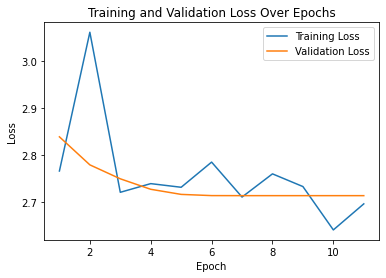

Test Accuracy: 6.76%
Test Precision: 0.0713
Test Recall: 0.0676
Test F1-Measure: 0.0646
Confusion Matrix:


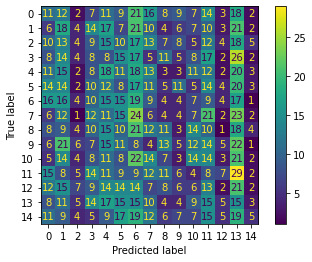

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


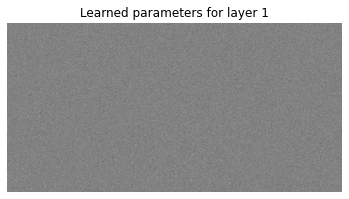

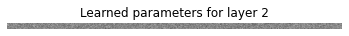

In [ ]:
#Experiment45
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.99, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows an increase and a decrease, validation error didn't continue to decrease after epoch 5. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.

Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.5739
Validation Loss at epoch 0: 3.1159
In epoch: 1
Training Loss in this epoch: 2.4574
Validation Loss at epoch 1: 2.9113
In epoch: 2
Training Loss in this epoch: 2.6588
Validation Loss at epoch 2: 2.7838
In epoch: 3
Training Loss in this epoch: 2.7634
Validation Loss at epoch 3: 2.7239
In epoch: 4
Training Loss in this epoch: 2.7190
Validation Loss at epoch 4: 2.7167
In epoch: 5
Training Loss in this epoch: 2.6828
Validation Loss at epoch 5: 2.7144
In epoch: 6
Training Loss in this epoch: 2.6972
Validation Loss at epoch 6: 2.7143
In epoch: 7
Training Loss in this epoch: 2.7346
Validation Loss at epoch 7: 2.7143
In epoch: 8
Training Loss in this epoch: 2.6722
Validation Loss at epoch 8: 2.7143
In epoch: 9
Training Loss in this epoch: 2.7393
Validation Loss at epoch 9: 2.7143
In epoch: 10
Training Loss in this epoch: 2.5733
Validation Loss at epoch 10: 2.7143
Early stopping at epoch 10


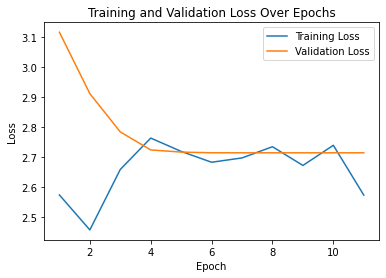

Test Accuracy: 7.16%
Test Precision: 0.0827
Test Recall: 0.0716
Test F1-Measure: 0.0690
Confusion Matrix:


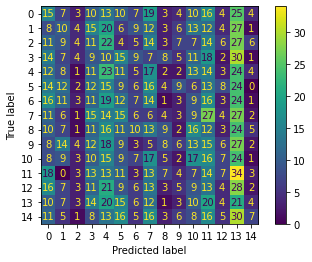

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


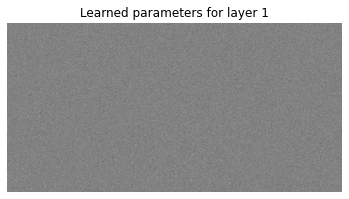

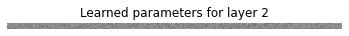

In [ ]:
#Experiment46
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.9, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease and an increase validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4.

Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.7392
Validation Loss at epoch 0: 2.8413
In epoch: 1
Training Loss in this epoch: 2.6257
Validation Loss at epoch 1: 2.9119
In epoch: 2
Training Loss in this epoch: 2.7668
Validation Loss at epoch 2: 2.7664
In epoch: 3
Training Loss in this epoch: 2.8379
Validation Loss at epoch 3: 2.7211
In epoch: 4
Training Loss in this epoch: 2.4999
Validation Loss at epoch 4: 2.7207
In epoch: 5
Training Loss in this epoch: 2.6644
Validation Loss at epoch 5: 2.7160
In epoch: 6
Training Loss in this epoch: 2.6029
Validation Loss at epoch 6: 2.7154
In epoch: 7
Training Loss in this epoch: 2.6131
Validation Loss at epoch 7: 2.7154
In epoch: 8
Training Loss in this epoch: 2.6462
Validation Loss at epoch 8: 2.7154
In epoch: 9
Training Loss in this epoch: 2.6735
Validation Loss at epoch 9: 2.7154
In epoch: 10
Training Loss in this epoch: 2.6489
Validation Loss at epoch 10: 2.7154
Early stopping at epoch 10


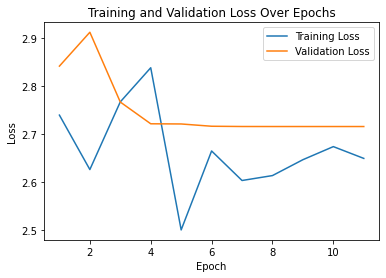

Test Accuracy: 6.67%
Test Precision: 0.0781
Test Recall: 0.0667
Test F1-Measure: 0.0657
Confusion Matrix:


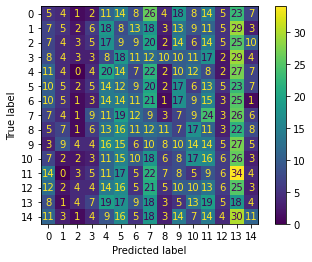

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


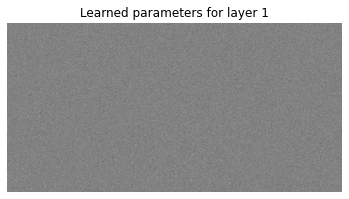

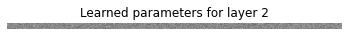

In [ ]:
#Experiment47
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.7, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease and an increase, validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 5.
Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

In epoch: 0


C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(A_output), np.array(intermediate_A), np.array(intermediate_Z)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1556\2271664968.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grads_dW), np.array(grads_db)


Training Loss in this epoch: 2.6681
Validation Loss at epoch 0: 2.8911
In epoch: 1
Training Loss in this epoch: 2.9534
Validation Loss at epoch 1: 2.9335
In epoch: 2
Training Loss in this epoch: 2.5913
Validation Loss at epoch 2: 2.8650
In epoch: 3
Training Loss in this epoch: 2.7109
Validation Loss at epoch 3: 2.7364
In epoch: 4
Training Loss in this epoch: 2.5886
Validation Loss at epoch 4: 2.7268
In epoch: 5
Training Loss in this epoch: 2.6218
Validation Loss at epoch 5: 2.7179
In epoch: 6
Training Loss in this epoch: 2.6176
Validation Loss at epoch 6: 2.7164
In epoch: 7
Training Loss in this epoch: 2.5731
Validation Loss at epoch 7: 2.7162
In epoch: 8
Training Loss in this epoch: 2.6464
Validation Loss at epoch 8: 2.7162
In epoch: 9
Training Loss in this epoch: 2.6568
Validation Loss at epoch 9: 2.7162
In epoch: 10
Training Loss in this epoch: 2.5869
Validation Loss at epoch 10: 2.7162
Early stopping at epoch 10


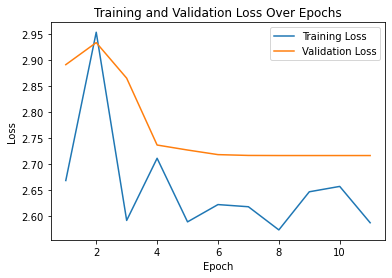

Test Accuracy: 7.33%
Test Precision: 0.0763
Test Recall: 0.0733
Test F1-Measure: 0.0708
Confusion Matrix:


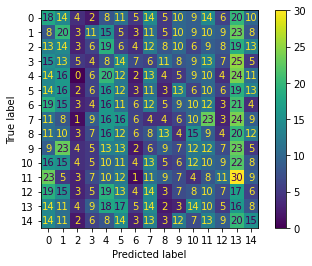

Parameters for layer 1 shape: (807, 1600)
Parameters for layer 2 shape: (15, 807)


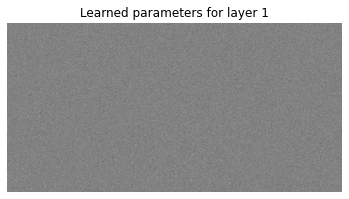

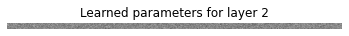

In [ ]:
#Experiment48
trained_parameters_w,trained_parameters_b, train_losses, val_losses,epoch = mini_batch_gradient_descent(train_x, train_y, val_x,val_y, initial_parameters_W,initial_parameters_b,activations,initial_learning_rate=0.02, decay_rate=0.5, num_epochs=100, batch_size=16 )
plot_losses(train_losses,val_losses,epoch)

test_predictions, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = predict_and_evaluate(test_x, test_y, trained_parameters_w, trained_parameters_b, activations)
display_output(test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix)
visualize_parameters(trained_parameters_w)

While training error shows a decrease validation error didn't continue to decrease after epoch 4. This shows even if we continue to the train the model it showed a bad generalization on the validation data which shows the model doesn't learn after epoch 4. Confusion matrix shows that this model is proned to predict class 14(class names startes from 0) more than other classes.

## Report of Part1

### Introduction

This is the report for Part1. It details the implementation and analysis of a Flower Species Image Classification system using a Multi-Layer Neural Network and discusses the 48 experiment results .Dataset for the model the Flower Species Dataset comprises 15 classes, each representing a different flower species. The aim of this homework is to create a multi layer network to classify the flower species in the dataset.

### Neural Network Architecture

I created 3 models and did 16 experiments on each one of them.  
  
Architecture of first model:  
First model consists of 2 hidden layers.  
Each hidden layer uses Relu activation.  
    
Architecture of second model:  
Second model consists of 1 hidden layer.  
Hidden layer uses Relu activation.  
    
Architecture of second model:  
Second model consists of 1 hidden layer.  
Hidden layer uses Relu activation.  
   
Architecture of third model:  
Third model consists of 1 hidden layer.  
Hidden layer uses sigmoid activation.  
  
Each model uses a average size of hidden layer size. This means layer size are reduces from input to output layer.  
I choose to use the sizes in a decreasing manner beause it a common practice and it often contributes to better model performance and efficiency.  
There is several reasons for employing decreasing layer sizes:  
1- Computational Efficiency:  
As the network processes input through layers, reducing the number of neurons in each subsequent layer decreases the overall computational cost of the model.  
2- Hierarchical Feature Extraction:  
The concept is based on the idea that earlier layers in a neural network learn low-level features, and deeper layers learn high-level or more abstract features. By reducing layer sizes progressively, the network tends to focus on capturing the most relevant and informative features, promoting hierarchical feature extraction.  
3- Dimensionality Reduction:  
Decreasing layer sizes can act as a form of dimensionality reduction.  
4- Regularization:  
Smaller layer sizes can act as a form of regularization. By reducing the capacity of the model (i.e., the number of parameters), the risk of overfitting to the training data is mitigated.  
5- Gradient Flow and Training Stability:  
When the number of neurons decreases, the network may have an easier time with backpropagation. The gradients may flow more smoothly during training, addressing issues like vanishing gradients and helping with the convergence of the optimization algorithm.  
  
Each model uses softmax activation for output layer.  
The reason for why every model uses softmax is the dataset is consists of 15 classes and if we want to classify all the classes we need an output of probabilities of each classes for a given image. Softmax results is a matrix of probabilities of each class, and they sum to 1. That's why softmax is used for multiclass classification and I used it in every model.  
  
What if we use different activation function in the output layer?  
Sigmoid Activation:  
Using sigmoid activation in each output neuron independently could work, but it doesn't ensure that the probabilities sum up to 1. Each output would represent the probability of belonging to a specific class independently, which may not be suitable for multiclass problems.  
ReLU or Other Activations:  
ReLU or similar activations are not suitable for the output layer of a classification model, especially when dealing with multiple classes. These activations lack the normalization properties of softmax, and doesn't provide a probabilistic interpretation.  

### Experiments and Results:

First I tried to train model with an image size of 84X90 with 2 hidden layers of  relu activaiton.  But the model trained 100 epoch in 3 hours. It was slow. So I reduced the image size to 40x40. When I reduced the size training time reduced to around 7 minutes for 100 epochs.

Experiment with Learning Rate: 0.02, Batch Size: 128  
Test Accuracy on epoch 100: 5.87%  
  
Experiment with Learning Rate: 0.02, Batch Size: 64  
Test Accuracy on epoch 100: 6.44%   
    
Experiment with Learning Rate: 0.02, Batch Size: 32  
Test Accuracy on epoch 100: 6.67%  
   
I stopped after this experiments because they are taking too much time.  
After running these experiments I added learning rate decay to the code.  
I added code for early stopping functionality and test the model performance on the validation data.  
I also added code for calculating precision recall f1 and confusion matrix after this 3 experiments so they don't have that results.

After that 
I did total of 48 experiments with 3 models.  
All the models used images with size 40x40.  

#### First Model

First model has 2 hidden layers with relu activation.  
First hidden layer size is 1076 and second hidden layer size is 538.  
Output layer uses softmax.  

I commented about results of each experiment after in the block after each experiment.  
In this part I will comment on the results of the experiments and compare them each other for the first model.  

experiment_name     decay_rate     batch_size     Accuracy       Precision       Recall       F1-Measure   
    1                   0.99          128           6.76%          0.0622        0.0676         0.0620  
    2                   0.9           128           6.76%          0.0628        0.0676         0.0628   
    3                   0.7           128           6.58%          0.0659        0.0658         0.0634   
    4                   0.5           128           7.24%          0.0699        0.0724         0.0696   
    5                   0.99          64            6.76%          0.0685        0.0676         0.0667   
    6                   0.9           64            6.89%          0.0674        0.0689         0.0671   
    7                   0.7           64            7.47%          0.0740        0.0747         0.0735   
    8                   0.5           64            7.20%          0.0718        0.0720         0.0705   
    9                   0.99          32            7.20%          0.0721        0.0720         0.0713    
    10                  0.9           32            7.16%          0.0717        0.0716         0.0709   
    11                  0.7           32            7.02%          0.0712        0.0702         0.0700   
    12                  0.5           32            7.07%          0.0710        0.0707         0.0703   
    13                  0.99          16            7.24%          0.0729        0.0724         0.0721   
    14                  0.9           16            7.16%          0.0722        0.0716         0.0714   
    15                  0.7           16            7.20%          0.0726        0.0720         0.0720    
    16                  0.5           16            7.42%          0.0749        0.0742         0.0744   

Decay Rate Impact:  
Observation: The experiments involve varying decay rates while keeping the batch size constant at 128,64,32 or 16.  
Comment: Higher decay rates (0.99) lead to slower learning, reflected in slightly lower accuracy for batch sizes 128,64,16. Lower decay rates (0.5) result in highest accuracy for batch sizes 128 and 16.   

Batch Size Impact:  
Observation: The experiments involve varying batch sizes with a constant decay rate of 0.99,0.9,0.7 or 0.5.  
Comment: Smaller batch sizes (16, 32, 64) generally lead to slightly better accuracy compared to larger batch sizes (128). This suggests that smaller batches might allow the model to converge more efficiently.  
  
The relationship between decay rate and batch size is can not be commented from this data because there is no visible correlation between them.   
    
Precision, Recall, F1-Score:  
Observation:F1-score shows an increase. For the two highest accuracies of experiment7(7.47%) and experiment16(7.42%) even though experiment7 has higher accuracy experiment 15's f1-score is higher. This can be commented as experiment15 is a best experiment for model1.  
Comment: Precision represents the accuracy of positive predictions, recall measures the ability to capture all relevant instances, and F1-score balances both. We can observe the results on f1-score instead of comment on them separately since the all there measures are low.  
    
Results:  
Despite variations in hyperparameters, the differences in accuracy, precision, recall, and F1-score are very small across experiments. If we consider accuracy even if we just select a random class for given image it's probability is 100/15 = 6.6667. Model 1 results slightly better than random assignment and this makes harder to interpret the experiment results since all result are bad in terms of classification performance. 


#### Second Model

First model has 1 hidden layer with relu activation.  
Hidden layer size is 807.  
Output layer uses softmax.  

I commented about results of each experiment after in the block after each experiment.  
In this part I will comment on the results of the experiments and compare them each other for the second model.  

experiment_name     decay_rate     batch_size     Accuracy       Precision       Recall       F1-Measure  
    17                0.99            128           6.58%          0.0697        0.0658         0.0656    
    18                0.9             128           6.49%          0.0628        0.0649         0.0606    
    19                0.7             128           6.76%          0.0671        0.0676         0.0651    
    20                0.5             128           6.89%          0.0705        0.0689         0.0679  
    21                0.99            64            7.47%          0.0773        0.0747         0.0744  
    22                0.9             64            7.24%          0.0744        0.0724         0.0715  
    23                0.7             64            7.33%          0.0748        0.0733         0.0731   
    24                0.5             64            7.42%          0.0744        0.0742         0.0733     
    25                0.99            32            7.29%          0.0719        0.0729         0.0715   
    26                0.9             32            7.24%          0.0728        0.0724         0.0721   
    27                0.7             32            7.11%          0.0719        0.0711         0.0708   
    28                0.5             32            7.42%          0.0750        0.0742         0.0743   
    29                0.99            16            7.24%          0.0744        0.0724         0.0729   
    30                0.9             16            7.11%          0.0728        0.0711         0.0717   
    31                0.7             16            6.98%          0.0711        0.0698         0.0701    
    32                0.5             16            6.93%          0.0701        0.0693         0.0695   

Decay Rate Impact:  
Observation: The experiments involve varying decay rates while keeping the batch size constant at 128,64,32 or 16.  
Comment:In experiments 17-20, there's a gradual increase in accuracy as the decay rate decreases from 0.99 to 0.5. While in experiments 29-32, there's a gradual decrease in accuracy as the decay rate decreases from 0.99 to 0.5. So it is hard to comment on the impact of decay rate in accuracy.  
  
Batch Size Impact:  
Observation: The experiments involve varying batch sizes with a constant decay rate of 0.99,0.9,0.7 or 0.5.  
Comment: Smaller batch sizes (16, 32, 64) generally lead to slightly better accuracy compared to larger batch sizes (128). This suggests that smaller batches might allow the model to converge more efficiently. Best accuracy's achieved on batch size 64. We can say that best batch size for model2 is 32.  
   
We might say relationship between decay rate and batch size is a trade-off. Best accuracy for batch size 128 observed when decay rate is 0.5 when best accuracy for batch size 16 observed when decay rate is 0.99.  
    
Precision, Recall, F1-Score:  
Observation:F1-score shows an increase and decrease as correlation with accuracy. For the batch size 64 best f1 scores observed. This can suggest that best experiment for this model is experiment21 with highest accuracy and f1 score.
Comment: Precision represents the accuracy of positive predictions, recall measures the ability to capture all relevant instances, and F1-score balances both. We can observe the results on f1-score instead of comment on them separately.   
    
Results:  
Despite variations in hyperparameters, the differences in accuracy, precision, recall, and F1-score are very small across experiments. If we consider accuracy even if we just select a random class for given image it's probability is 100/15 = 6.6667. Model 2 results slightly better than random assignment and this makes harder to interpret the experiment results since all result are bad in terms of classification performance. 

#### Third Model

First model has 1 hidden layer with relu activation.  
Hidden layer size is 807.  
Output layer uses softmax.  

I commented about results of each experiment after in the block after each experiment.  
In this part I will comment on the results of the experiments and compare them each other for the third model.  

experiment_name     decay_rate     batch_size     Accuracy       Precision       Recall       F1-Measure   
    33                0.99           128            7.07%          0.1339        0.0707         0.0466  
    34                0.9            128            6.76%          0.0830        0.0676         0.0465  
    35                0.7            128            6.89%          0.0687        0.0689         0.0549  
    36                0.5            128            7.24%          0.0768        0.0724         0.0632   
    37                0.99            64            7.16%          0.0737        0.0716         0.0628  
    38                0.9             64            6.62%          0.0670        0.0662         0.0531   
    39                0.7             64            7.47%          0.0756        0.0747         0.0623  
    40                0.5             64            6.84%          0.0627        0.0684         0.0568   
    41                0.99            32            6.71%          0.0707        0.0671         0.0589  
    42                0.9             32            6.62%          0.0724        0.0662         0.0623   
    43                0.7             32            6.80%          0.0704        0.0680         0.0607    
    44                0.5             32            6.89%          0.0786        0.0689         0.0666   
    45                0.99            16            6.76%          0.0713        0.0676         0.0646   
    46                0.9             16            7.16%          0.0827        0.0716         0.0690    
    47                0.7             16            6.67%          0.0781        0.0667         0.0657   
    48                0.5             16            7.33%          0.0763        0.0733         0.0708   

Decay Rate Impact:  
Observation: The experiments involve varying decay rates while keeping the batch size constant at 128,64,32 or 16.  
Comment:In experiments 33-36, there's a gradual increase in accuracy as the decay rate decreases from 0.99 to 0.5. But we can not say it's general pattern of the model beause it does not observed again.   
  
Batch Size Impact:   
Observation: The experiments involve varying batch sizes with a constant decay rate of 0.99,0.9,0.7 or 0.5.  
Comment: Accuracy results are similar between the batch sizes.  It is hard to comment on the impact of the batch size on the model.   
    
The relationship between decay rate and batch size is can not be commented from this data because there is no visible correlation between them.   
    
Precision, Recall, F1-Score:  
Observation:For the two highest accuracies of experiment39(7.47%) and experiment48(7.33%) even though experiment39 has higher accuracy experiment 48's f1-score is higher. This can be commented as experiment48 might be the best experiment for model3. 
Comment: Precision represents the accuracy of positive predictions, recall measures the ability to capture all relevant instances, and F1-score balances both. We can observe the results on f1-score instead of comment on them separately. 
    
Results:  
Despite variations in hyperparameters, the differences in accuracy, precision, recall, and F1-score are very small across experiments. If we consider accuracy even if we just select a random class for given image it's probability is 100/15 = 6.6667. Model 3 results slightly better than random assignment and this makes harder to interpret the experiment results since all result are bad in terms of classification performance. 

#### Comparison of the all models

Decay Rate and Batch Sizes: Across all experiments and models, there is a consistent trend where lower decay rates and smaller batch sizes tend to lead to improved performance in terms of accuracy, precision, recall, and F1-measure.  
Accuracy: The achieved accuracy values across all experiments are relatively low. This suggests that the models may face challenges in effectively learning from the dataset.  
Sensitivity to Hyperparameters: The models appear to be sensitive to hyperparameters, particularly decay rate and batch size. Smaller batch sizes consistently show better performance, indicating that the models benefit from more frequent updates.  
Further Optimization Needed: The observed results indicate that further optimization of the neural network architecture, activation functions, and learning algorithms may be necessary to achieve higher accuracy and robust generalization. Can not comment on the impacts of the activation functions in hidden layers or the hidden layer number because accuracy levels similar and low for each model. Low accuracy means all the models are underfitted and need to optimized. 1 or 2 hidden layer is considered as small numbers for constructing a model for image classification. Since we have an image as input we have large size of input parameters. In these experiments 1600. Converting this 1600 parameter to 15 in one or two layer might not result in a good learning. So we need to increase the number of the hidden layers. The trend for activation function is using relu because it is less expensive in computation wise but it allows to mute some units as it can set their weight to 0. I think a much larger model which has more than 2 hidden layers and uses relu for activation funtion might be a better model for this dataset. If we use a model that can large enough to have much more input parameters using rgb image as input can result better results. Because there is more information of the data in the rgb image than the grayscale image.  